In [1]:
import gensim
import os
import collections
import smart_open
import random
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from pprint import pprint
import numpy as np
from sklearn import svm
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint

/home/hao/anaconda3/envs/MLOntology/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#global variabls

directory_path = "/home/hao/AnacondaProjects/MLOntology/NCIt/"
data_path = directory_path + "data/"
vector_model_path = directory_path +"vectorModel/"
cnn_model_path = directory_path +"cnnModel/"


In [3]:
import re
def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

In [4]:
#read class label file
#create mapping from id to labels  
#iso-8859-1 , encoding="iso-8859-1"
conceptLabelDict={}
errors=[]

def read_label(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==3:
                conceptID = get_trailing_number(splitted[1])
                conceptLabelDict[conceptID] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

label_file = data_path + "ontClassLabels_owl_ncit.txt"
read_label(label_file)
print(conceptLabelDict["4863"])
print(conceptLabelDict["115117"])
print(errors)

prostate carcinoma
stage ia esophageal cancer ajcc v7
[]


In [5]:
conceptPairDict={}
errors=[]
conceptPairList=[]

def read_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==3:
                childID = get_trailing_number(splitted[1])
                parentID = get_trailing_number(splitted[2].replace("\r\n", ""))
                conceptPairList.append([childID, parentID , 1])
#                 conceptPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

pair_file = data_path + "ontHierarchy_owl_ncit.txt"
read_pair(pair_file)

checkpairs = conceptPairList[10:15]
print(checkpairs)
print(len(conceptPairList))

[['4861', '7318', 1], ['87152', '87150', 1], ['87153', '140032', 1], ['87154', '87153', 1], ['87155', '87153', 1]]
16533


In [6]:
conceptNotPairDict={}
conceptNotPairList=[]

def read_not_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==2:
                childID = get_trailing_number(splitted[0])
                notparentID = get_trailing_number(splitted[1].replace("\r\n", ""))
                conceptNotPairList.append([childID, notparentID, 0])
#                 conceptNotPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

notPair_file = data_path + "taxNotPairs_owl_ncit.txt"
read_not_pair(notPair_file)


first2pairs =conceptNotPairList[10:15]
print(first2pairs)
print(len(conceptNotPairList))

[['86053', '88414', 0], ['8784', '7917', 0], ['141358', '141347', 0], ['141358', '141353', 0], ['141358', '141350', 0]]
9533


In [7]:
# In-place shuffle
random.shuffle(conceptNotPairList)
conceptNotPairList = conceptNotPairList[:len(conceptPairList)]

print(len(conceptNotPairList))

9533


In [8]:
vector_model_file = vector_model_path + "model0"

vector_model = gensim.models.Doc2Vec.load(vector_model_file)

inferred_vector = vector_model.infer_vector(['congenital', 'prolong', 'rupture', 'premature', 'membrane', 'lung'])
pprint(vector_model.docvecs.most_similar([inferred_vector], topn=10))

[('4453', 0.6528493165969849),
 ('5348', 0.6484999060630798),
 ('27710', 0.6466124057769775),
 ('7779', 0.6465014219284058),
 ('3497', 0.6452109813690186),
 ('3723', 0.6363397240638733),
 ('4888', 0.6361851692199707),
 ('5383', 0.6355826258659363),
 ('5671', 0.6329636573791504),
 ('7388', 0.6316972970962524)]


In [11]:
vector_model.docvecs['7918']

array([ 0.12609509, -0.14391775, -0.20320868,  0.13559805, -0.08202884,
        0.10722277,  0.18199387, -0.26228553,  0.04246611, -0.00649435,
        0.10294101, -0.27283564, -0.29595587, -0.13510123, -0.18745899,
       -0.06876425,  0.10115382,  0.2984237 , -0.12548344,  0.03356226,
       -0.27210802,  0.03674074,  0.11773712, -0.14497988,  0.05709781,
        0.28865436,  0.15237136,  0.00179479,  0.13180228, -0.02415455,
        0.01091036,  0.36455607,  0.06222258,  0.11164229,  0.23434547,
       -0.07381882,  0.01397681, -0.28311065, -0.22567365,  0.23147786,
       -0.1453279 , -0.06648812,  0.23720746,  0.19410881, -0.06170202,
       -0.24025288, -0.21693215,  0.28687826,  0.27896526,  0.00860866,
       -0.2562113 , -0.18602385,  0.10781734,  0.26041856, -0.18571755,
        0.18337673, -0.23598352, -0.33744544, -0.3776818 , -0.20338072,
       -0.23119031,  0.03834419,  0.21261531, -0.08705533, -0.12815018,
        0.16839027, -0.3945968 , -0.12569514, -0.05599431,  0.41

In [ ]:
vector_model_file = vector_model_path + "model1"

vector_model = gensim.models.Doc2Vec.load(vector_model_file)

inferred_vector = vector_model.infer_vector(['congenital', 'prolong', 'rupture', 'premature', 'membrane', 'lung'])
pprint(vector_model.docvecs.most_similar([inferred_vector], topn=10))

In [12]:
feature_number = 1024

def readFromPairList(id_pair_list, id_notPair_list):
    pair_list = id_pair_list + id_notPair_list
    random.shuffle(pair_list)
    idpairs_list =[]
    label_list =[]
    for i, line in enumerate(pair_list):      
        idpairs_list.append([line[0], line[1]])
        label_list.append(line[2])
    return idpairs_list, label_list

idpairs_list, label_list= readFromPairList(conceptPairList, conceptNotPairList)

print(label_list[:20])

[0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(idpairs_list, label_list, test_size = 0.2, shuffle= True)
print(X_train[:20])
print(X_validation[:20])
print(y_train[:20])
print(y_validation[:20])

[['7442', '4242'], ['90016', '89989'], ['37196', '9470'], ['5513', '38162'], ['139536', '139541'], ['8042', '91256'], ['133423', '133424'], ['8915', '27786'], ['3863', '36090'], ['7186', '50477'], ['8063', '3517'], ['123906', '6283'], ['3768', '4197'], ['5223', '7831'], ['27683', '27674'], ['89991', '89989'], ['9290', '27134'], ['8203', '5884'], ['38762', '3772'], ['3994', '8514']]
[['7008', '3520'], ['3761', '6797'], ['88158', '88150'], ['4555', '6104'], ['6429', '6422'], ['27426', '27423'], ['6834', '2855'], ['7347', '27093'], ['27739', '9403'], ['8118', '9108'], ['67455', '87778'], ['140517', '140522'], ['136469', '90519'], ['8573', '5771'], ['7800', '141143'], ['7076', '50477'], ['5503', '27134'], ['43313', '3377'], ['8994', '34774'], ['85896', '85900']]
[1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0]


In [24]:
feature_number = 1024

def getVectorFromModel(concept_id, conceptLabelDict, model):
    if concept_id in model.docvecs:
        concept_vector= model.docvecs[concept_id]
    else:
        print("%s not found, get inferred vector "%(concept_id))
        concept_label = conceptLabelDict[concept_id]
        concept_vector= model.infer_vector(concept_label.split())
    return concept_vector

def getVector(line, conceptLabelDict, model):        
    a = getVectorFromModel(line[0], conceptLabelDict, model)
    b = getVectorFromModel(line[1], conceptLabelDict, model)
    c = np.array((a, b))
    c = c.T 
#     c = np.expand_dims(c, axis=2)
#     print(c.shape)
    return c

In [15]:
def stackVector(vector):
    from numpy import dstack
    return dstack((vector, vector, vector))

In [ ]:
n_channels=2 

def generator(x_samples, y_samples, train_flag, batch_size=64):
    samples = list(zip(x_samples, y_samples))
    num_samples = len(samples)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            X_samples = []
            Y_samples= []
            for batch_sample in batch_samples:
                pair_list = batch_sample[0]
                data_vector = getVector(pair_list, conceptLabelDict, vector_model)
                data_vector = stackVector(data_vector)
                print(data_vector.shape)
                X_samples.append(data_vector)
                class_label = batch_sample[1] 
                Y_samples.append(class_label)
                
            X_samples = np.array(X_samples).astype('float32')
            Y_samples = np.eye(n_channels)[Y_samples]
            print('one batch ready')
            yield shuffle(X_samples, Y_samples)

In [32]:
n_channels=2 

def get_batches(x_samples, y_samples, batch_size=64):
    samples = list(zip(x_samples, y_samples))
    num_samples = len(samples)
    
    shuffle(samples)
    for offset in range(0, num_samples, batch_size):
        batch_samples = samples[offset:offset+batch_size]

        X_samples = []
        Y_samples= []
        for batch_sample in batch_samples:
            pair_list = batch_sample[0]
            data_vector = getVector(pair_list, conceptLabelDict, vector_model)
#                 data_vector = stackVector(data_vector)
#                 print(data_vector.shape)
            X_samples.append(data_vector)
            class_label = batch_sample[1] 
            Y_samples.append(class_label)

        X_samples = np.array(X_samples).astype('float32')
        Y_samples = np.eye(n_channels)[Y_samples]
#             print('one batch ready')
        yield shuffle(X_samples, Y_samples)

def get_batches(X, y, batch_size = 100):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [ ]:
set_batch_size = 64

# compile and train the model using the generator function
train_generator = generator(X_train, y_train, train_flag=True, batch_size=set_batch_size)
validation_generator = generator(X_validation, y_validation, train_flag=False, batch_size=set_batch_size)

In [17]:
from keras import applications
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

import numpy as np

In [18]:
# Imports
import tensorflow as tf

In [22]:
# build the model??
batch_size = 64       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 2
n_channels = 2


graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

    
with graph.as_default():
    # (batch, 128, 2) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')


with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



In [20]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [34]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_train, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 50 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%100 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_validation, y_validation, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 50 Train loss: 0.620552 Train acc: 0.687500
Epoch: 0/1000 Iteration: 100 Train loss: 0.634636 Train acc: 0.625000
Epoch: 0/1000 Iteration: 100 Validation loss: 0.636170 Validation acc: 0.630412
Epoch: 0/1000 Iteration: 150 Train loss: 0.622094 Train acc: 0.656250
Epoch: 0/1000 Iteration: 200 Train loss: 0.653944 Train acc: 0.546875
Epoch: 0/1000 Iteration: 200 Validation loss: 0.620028 Validation acc: 0.630412
Epoch: 0/1000 Iteration: 250 Train loss: 0.571908 Train acc: 0.703125
Epoch: 0/1000 Iteration: 300 Train loss: 0.551546 Train acc: 0.687500
Epoch: 0/1000 Iteration: 300 Validation loss: 0.588580 Validation acc: 0.638986
Epoch: 1/1000 Iteration: 350 Train loss: 0.470442 Train acc: 0.843750
Epoch: 1/1000 Iteration: 400 Train loss: 0.531884 Train acc: 0.765625
Epoch: 1/1000 Iteration: 400 Validation loss: 0.536341 Validation acc: 0.773094
Epoch: 1/1000 Iteration: 450 Train loss: 0.543801 Train acc: 0.718750
Epoch: 1/1000 Iteration: 500 Train loss: 0.413487 T

Epoch: 11/1000 Iteration: 3750 Train loss: 0.354434 Train acc: 0.875000
Epoch: 11/1000 Iteration: 3800 Train loss: 0.484802 Train acc: 0.828125
Epoch: 11/1000 Iteration: 3800 Validation loss: 0.331204 Validation acc: 0.853239
Epoch: 11/1000 Iteration: 3850 Train loss: 0.321337 Train acc: 0.828125
Epoch: 11/1000 Iteration: 3900 Train loss: 0.358768 Train acc: 0.843750
Epoch: 11/1000 Iteration: 3900 Validation loss: 0.330017 Validation acc: 0.848717
Epoch: 12/1000 Iteration: 3950 Train loss: 0.404900 Train acc: 0.781250
Epoch: 12/1000 Iteration: 4000 Train loss: 0.446465 Train acc: 0.828125
Epoch: 12/1000 Iteration: 4000 Validation loss: 0.329160 Validation acc: 0.848717
Epoch: 12/1000 Iteration: 4050 Train loss: 0.349533 Train acc: 0.812500
Epoch: 12/1000 Iteration: 4100 Train loss: 0.249696 Train acc: 0.937500
Epoch: 12/1000 Iteration: 4100 Validation loss: 0.331379 Validation acc: 0.854738
Epoch: 12/1000 Iteration: 4150 Train loss: 0.349337 Train acc: 0.843750
Epoch: 12/1000 Iteration

Epoch: 22/1000 Iteration: 7400 Train loss: 0.398339 Train acc: 0.812500
Epoch: 22/1000 Iteration: 7400 Validation loss: 0.296727 Validation acc: 0.866819
Epoch: 22/1000 Iteration: 7450 Train loss: 0.156683 Train acc: 0.937500
Epoch: 23/1000 Iteration: 7500 Train loss: 0.357187 Train acc: 0.859375
Epoch: 23/1000 Iteration: 7500 Validation loss: 0.295448 Validation acc: 0.868153
Epoch: 23/1000 Iteration: 7550 Train loss: 0.322033 Train acc: 0.843750
Epoch: 23/1000 Iteration: 7600 Train loss: 0.307304 Train acc: 0.906250
Epoch: 23/1000 Iteration: 7600 Validation loss: 0.297927 Validation acc: 0.863199
Epoch: 23/1000 Iteration: 7650 Train loss: 0.303575 Train acc: 0.843750
Epoch: 23/1000 Iteration: 7700 Train loss: 0.392126 Train acc: 0.828125
Epoch: 23/1000 Iteration: 7700 Validation loss: 0.296015 Validation acc: 0.865866
Epoch: 23/1000 Iteration: 7750 Train loss: 0.307615 Train acc: 0.859375
Epoch: 23/1000 Iteration: 7800 Train loss: 0.320134 Train acc: 0.843750
Epoch: 23/1000 Iteration

Epoch: 33/1000 Iteration: 11000 Validation loss: 0.279130 Validation acc: 0.874060
Epoch: 33/1000 Iteration: 11050 Train loss: 0.134747 Train acc: 0.937500
Epoch: 34/1000 Iteration: 11100 Train loss: 0.416439 Train acc: 0.750000
Epoch: 34/1000 Iteration: 11100 Validation loss: 0.277495 Validation acc: 0.876131
Epoch: 34/1000 Iteration: 11150 Train loss: 0.334743 Train acc: 0.890625
Epoch: 34/1000 Iteration: 11200 Train loss: 0.293258 Train acc: 0.875000
Epoch: 34/1000 Iteration: 11200 Validation loss: 0.280932 Validation acc: 0.873603
Epoch: 34/1000 Iteration: 11250 Train loss: 0.260956 Train acc: 0.906250
Epoch: 34/1000 Iteration: 11300 Train loss: 0.314357 Train acc: 0.859375
Epoch: 34/1000 Iteration: 11300 Validation loss: 0.275874 Validation acc: 0.876486
Epoch: 34/1000 Iteration: 11350 Train loss: 0.283696 Train acc: 0.875000
Epoch: 34/1000 Iteration: 11400 Train loss: 0.342398 Train acc: 0.828125
Epoch: 34/1000 Iteration: 11400 Validation loss: 0.276613 Validation acc: 0.875584
E

Epoch: 44/1000 Iteration: 14600 Validation loss: 0.263261 Validation acc: 0.880678
Epoch: 44/1000 Iteration: 14650 Train loss: 0.242697 Train acc: 0.906250
Epoch: 45/1000 Iteration: 14700 Train loss: 0.234191 Train acc: 0.875000
Epoch: 45/1000 Iteration: 14700 Validation loss: 0.264321 Validation acc: 0.882279
Epoch: 45/1000 Iteration: 14750 Train loss: 0.165028 Train acc: 0.921875
Epoch: 45/1000 Iteration: 14800 Train loss: 0.255562 Train acc: 0.890625
Epoch: 45/1000 Iteration: 14800 Validation loss: 0.271299 Validation acc: 0.879281
Epoch: 45/1000 Iteration: 14850 Train loss: 0.309892 Train acc: 0.859375
Epoch: 45/1000 Iteration: 14900 Train loss: 0.244407 Train acc: 0.890625
Epoch: 45/1000 Iteration: 14900 Validation loss: 0.262067 Validation acc: 0.882965
Epoch: 45/1000 Iteration: 14950 Train loss: 0.222082 Train acc: 0.875000
Epoch: 46/1000 Iteration: 15000 Train loss: 0.259450 Train acc: 0.875000
Epoch: 46/1000 Iteration: 15000 Validation loss: 0.262252 Validation acc: 0.882825
E

Epoch: 55/1000 Iteration: 18200 Validation loss: 0.251796 Validation acc: 0.889469
Epoch: 55/1000 Iteration: 18250 Train loss: 0.223232 Train acc: 0.906250
Epoch: 56/1000 Iteration: 18300 Train loss: 0.167908 Train acc: 0.953125
Epoch: 56/1000 Iteration: 18300 Validation loss: 0.250715 Validation acc: 0.889444
Epoch: 56/1000 Iteration: 18350 Train loss: 0.294989 Train acc: 0.859375
Epoch: 56/1000 Iteration: 18400 Train loss: 0.360398 Train acc: 0.828125
Epoch: 56/1000 Iteration: 18400 Validation loss: 0.252843 Validation acc: 0.885988
Epoch: 56/1000 Iteration: 18450 Train loss: 0.227357 Train acc: 0.906250
Epoch: 56/1000 Iteration: 18500 Train loss: 0.187668 Train acc: 0.890625
Epoch: 56/1000 Iteration: 18500 Validation loss: 0.253004 Validation acc: 0.888377
Epoch: 56/1000 Iteration: 18550 Train loss: 0.265482 Train acc: 0.921875
Epoch: 57/1000 Iteration: 18600 Train loss: 0.217769 Train acc: 0.906250
Epoch: 57/1000 Iteration: 18600 Validation loss: 0.250879 Validation acc: 0.889660
E

Epoch: 66/1000 Iteration: 21800 Validation loss: 0.246845 Validation acc: 0.891235
Epoch: 67/1000 Iteration: 21850 Train loss: 0.379011 Train acc: 0.828125
Epoch: 67/1000 Iteration: 21900 Train loss: 0.214665 Train acc: 0.906250
Epoch: 67/1000 Iteration: 21900 Validation loss: 0.245624 Validation acc: 0.891590
Epoch: 67/1000 Iteration: 21950 Train loss: 0.169462 Train acc: 0.937500
Epoch: 67/1000 Iteration: 22000 Train loss: 0.429595 Train acc: 0.843750
Epoch: 67/1000 Iteration: 22000 Validation loss: 0.248509 Validation acc: 0.890282
Epoch: 67/1000 Iteration: 22050 Train loss: 0.285691 Train acc: 0.890625
Epoch: 67/1000 Iteration: 22100 Train loss: 0.167272 Train acc: 0.937500
Epoch: 67/1000 Iteration: 22100 Validation loss: 0.242299 Validation acc: 0.895592
Epoch: 67/1000 Iteration: 22150 Train loss: 0.205734 Train acc: 0.906250
Epoch: 68/1000 Iteration: 22200 Train loss: 0.234046 Train acc: 0.921875
Epoch: 68/1000 Iteration: 22200 Validation loss: 0.243301 Validation acc: 0.894830
E

Epoch: 77/1000 Iteration: 25400 Validation loss: 0.239283 Validation acc: 0.894207
Epoch: 78/1000 Iteration: 25450 Train loss: 0.338315 Train acc: 0.890625
Epoch: 78/1000 Iteration: 25500 Train loss: 0.221935 Train acc: 0.906250
Epoch: 78/1000 Iteration: 25500 Validation loss: 0.233596 Validation acc: 0.898806
Epoch: 78/1000 Iteration: 25550 Train loss: 0.224676 Train acc: 0.890625
Epoch: 78/1000 Iteration: 25600 Train loss: 0.198983 Train acc: 0.921875
Epoch: 78/1000 Iteration: 25600 Validation loss: 0.234742 Validation acc: 0.900381
Epoch: 78/1000 Iteration: 25650 Train loss: 0.240190 Train acc: 0.906250
Epoch: 78/1000 Iteration: 25700 Train loss: 0.191276 Train acc: 0.875000
Epoch: 78/1000 Iteration: 25700 Validation loss: 0.234558 Validation acc: 0.898996
Epoch: 78/1000 Iteration: 25750 Train loss: 0.257478 Train acc: 0.906250
Epoch: 79/1000 Iteration: 25800 Train loss: 0.212730 Train acc: 0.890625
Epoch: 79/1000 Iteration: 25800 Validation loss: 0.233942 Validation acc: 0.899568
E

Epoch: 88/1000 Iteration: 29000 Validation loss: 0.240186 Validation acc: 0.893521
Epoch: 89/1000 Iteration: 29050 Train loss: 0.248229 Train acc: 0.937500
Epoch: 89/1000 Iteration: 29100 Train loss: 0.115739 Train acc: 0.937500
Epoch: 89/1000 Iteration: 29100 Validation loss: 0.228444 Validation acc: 0.902642
Epoch: 89/1000 Iteration: 29150 Train loss: 0.201749 Train acc: 0.875000
Epoch: 89/1000 Iteration: 29200 Train loss: 0.299068 Train acc: 0.843750
Epoch: 89/1000 Iteration: 29200 Validation loss: 0.236638 Validation acc: 0.896684
Epoch: 89/1000 Iteration: 29250 Train loss: 0.339193 Train acc: 0.828125
Epoch: 89/1000 Iteration: 29300 Train loss: 0.141131 Train acc: 0.953125
Epoch: 89/1000 Iteration: 29300 Validation loss: 0.235774 Validation acc: 0.894804
Epoch: 90/1000 Iteration: 29350 Train loss: 0.223297 Train acc: 0.906250
Epoch: 90/1000 Iteration: 29400 Train loss: 0.205962 Train acc: 0.890625
Epoch: 90/1000 Iteration: 29400 Validation loss: 0.227922 Validation acc: 0.903455
E

Epoch: 99/1000 Iteration: 32600 Validation loss: 0.221162 Validation acc: 0.907622
Epoch: 100/1000 Iteration: 32650 Train loss: 0.238389 Train acc: 0.921875
Epoch: 100/1000 Iteration: 32700 Train loss: 0.226418 Train acc: 0.890625
Epoch: 100/1000 Iteration: 32700 Validation loss: 0.224241 Validation acc: 0.904192
Epoch: 100/1000 Iteration: 32750 Train loss: 0.200994 Train acc: 0.906250
Epoch: 100/1000 Iteration: 32800 Train loss: 0.175899 Train acc: 0.890625
Epoch: 100/1000 Iteration: 32800 Validation loss: 0.222153 Validation acc: 0.905932
Epoch: 100/1000 Iteration: 32850 Train loss: 0.220246 Train acc: 0.921875
Epoch: 100/1000 Iteration: 32900 Train loss: 0.163513 Train acc: 0.937500
Epoch: 100/1000 Iteration: 32900 Validation loss: 0.223761 Validation acc: 0.903188
Epoch: 101/1000 Iteration: 32950 Train loss: 0.185607 Train acc: 0.937500
Epoch: 101/1000 Iteration: 33000 Train loss: 0.187636 Train acc: 0.921875
Epoch: 101/1000 Iteration: 33000 Validation loss: 0.220574 Validation acc

Epoch: 110/1000 Iteration: 36150 Train loss: 0.201927 Train acc: 0.921875
Epoch: 111/1000 Iteration: 36200 Train loss: 0.255935 Train acc: 0.890625
Epoch: 111/1000 Iteration: 36200 Validation loss: 0.215471 Validation acc: 0.910887
Epoch: 111/1000 Iteration: 36250 Train loss: 0.240278 Train acc: 0.890625
Epoch: 111/1000 Iteration: 36300 Train loss: 0.215387 Train acc: 0.875000
Epoch: 111/1000 Iteration: 36300 Validation loss: 0.221159 Validation acc: 0.903405
Epoch: 111/1000 Iteration: 36350 Train loss: 0.273014 Train acc: 0.859375
Epoch: 111/1000 Iteration: 36400 Train loss: 0.196113 Train acc: 0.906250
Epoch: 111/1000 Iteration: 36400 Validation loss: 0.216227 Validation acc: 0.910315
Epoch: 111/1000 Iteration: 36450 Train loss: 0.163702 Train acc: 0.953125
Epoch: 111/1000 Iteration: 36500 Train loss: 0.152436 Train acc: 0.953125
Epoch: 111/1000 Iteration: 36500 Validation loss: 0.226970 Validation acc: 0.903214
Epoch: 112/1000 Iteration: 36550 Train loss: 0.224393 Train acc: 0.89062

Epoch: 121/1000 Iteration: 39700 Train loss: 0.153665 Train acc: 0.953125
Epoch: 121/1000 Iteration: 39700 Validation loss: 0.216089 Validation acc: 0.908359
Epoch: 121/1000 Iteration: 39750 Train loss: 0.256148 Train acc: 0.890625
Epoch: 122/1000 Iteration: 39800 Train loss: 0.173181 Train acc: 0.937500
Epoch: 122/1000 Iteration: 39800 Validation loss: 0.210169 Validation acc: 0.912983
Epoch: 122/1000 Iteration: 39850 Train loss: 0.130075 Train acc: 0.968750
Epoch: 122/1000 Iteration: 39900 Train loss: 0.160549 Train acc: 0.921875
Epoch: 122/1000 Iteration: 39900 Validation loss: 0.217813 Validation acc: 0.908600
Epoch: 122/1000 Iteration: 39950 Train loss: 0.256624 Train acc: 0.890625
Epoch: 122/1000 Iteration: 40000 Train loss: 0.187566 Train acc: 0.921875
Epoch: 122/1000 Iteration: 40000 Validation loss: 0.212989 Validation acc: 0.910696
Epoch: 122/1000 Iteration: 40050 Train loss: 0.134226 Train acc: 0.937500
Epoch: 123/1000 Iteration: 40100 Train loss: 0.205060 Train acc: 0.89062

Epoch: 132/1000 Iteration: 43200 Validation loss: 0.206498 Validation acc: 0.915079
Epoch: 132/1000 Iteration: 43250 Train loss: 0.135032 Train acc: 0.937500
Epoch: 132/1000 Iteration: 43300 Train loss: 0.179285 Train acc: 0.937500
Epoch: 132/1000 Iteration: 43300 Validation loss: 0.207053 Validation acc: 0.915295
Epoch: 132/1000 Iteration: 43350 Train loss: 0.136195 Train acc: 0.968750
Epoch: 133/1000 Iteration: 43400 Train loss: 0.128941 Train acc: 0.984375
Epoch: 133/1000 Iteration: 43400 Validation loss: 0.205949 Validation acc: 0.916959
Epoch: 133/1000 Iteration: 43450 Train loss: 0.169745 Train acc: 0.953125
Epoch: 133/1000 Iteration: 43500 Train loss: 0.124204 Train acc: 0.937500
Epoch: 133/1000 Iteration: 43500 Validation loss: 0.207239 Validation acc: 0.913364
Epoch: 133/1000 Iteration: 43550 Train loss: 0.177899 Train acc: 0.937500
Epoch: 133/1000 Iteration: 43600 Train loss: 0.157192 Train acc: 0.953125
Epoch: 133/1000 Iteration: 43600 Validation loss: 0.211121 Validation ac

Epoch: 143/1000 Iteration: 46750 Train loss: 0.132081 Train acc: 0.953125
Epoch: 143/1000 Iteration: 46800 Train loss: 0.148656 Train acc: 0.953125
Epoch: 143/1000 Iteration: 46800 Validation loss: 0.203928 Validation acc: 0.917581
Epoch: 143/1000 Iteration: 46850 Train loss: 0.233126 Train acc: 0.890625
Epoch: 143/1000 Iteration: 46900 Train loss: 0.126811 Train acc: 0.953125
Epoch: 143/1000 Iteration: 46900 Validation loss: 0.206892 Validation acc: 0.912360
Epoch: 144/1000 Iteration: 46950 Train loss: 0.197323 Train acc: 0.906250
Epoch: 144/1000 Iteration: 47000 Train loss: 0.099006 Train acc: 0.953125
Epoch: 144/1000 Iteration: 47000 Validation loss: 0.207506 Validation acc: 0.912360
Epoch: 144/1000 Iteration: 47050 Train loss: 0.166404 Train acc: 0.937500
Epoch: 144/1000 Iteration: 47100 Train loss: 0.179359 Train acc: 0.921875
Epoch: 144/1000 Iteration: 47100 Validation loss: 0.203438 Validation acc: 0.916603
Epoch: 144/1000 Iteration: 47150 Train loss: 0.249727 Train acc: 0.87500

Epoch: 154/1000 Iteration: 50300 Train loss: 0.147006 Train acc: 0.937500
Epoch: 154/1000 Iteration: 50300 Validation loss: 0.201492 Validation acc: 0.918128
Epoch: 154/1000 Iteration: 50350 Train loss: 0.097176 Train acc: 0.984375
Epoch: 154/1000 Iteration: 50400 Train loss: 0.105424 Train acc: 0.984375
Epoch: 154/1000 Iteration: 50400 Validation loss: 0.202131 Validation acc: 0.918178
Epoch: 154/1000 Iteration: 50450 Train loss: 0.359085 Train acc: 0.843750
Epoch: 154/1000 Iteration: 50500 Train loss: 0.220290 Train acc: 0.859375
Epoch: 154/1000 Iteration: 50500 Validation loss: 0.202325 Validation acc: 0.914101
Epoch: 155/1000 Iteration: 50550 Train loss: 0.217111 Train acc: 0.937500
Epoch: 155/1000 Iteration: 50600 Train loss: 0.217731 Train acc: 0.890625
Epoch: 155/1000 Iteration: 50600 Validation loss: 0.201575 Validation acc: 0.916006
Epoch: 155/1000 Iteration: 50650 Train loss: 0.164627 Train acc: 0.953125
Epoch: 155/1000 Iteration: 50700 Train loss: 0.171368 Train acc: 0.89062

Epoch: 165/1000 Iteration: 53800 Validation loss: 0.194490 Validation acc: 0.921773
Epoch: 165/1000 Iteration: 53850 Train loss: 0.153598 Train acc: 0.968750
Epoch: 165/1000 Iteration: 53900 Train loss: 0.125583 Train acc: 0.921875
Epoch: 165/1000 Iteration: 53900 Validation loss: 0.197794 Validation acc: 0.918128
Epoch: 165/1000 Iteration: 53950 Train loss: 0.207156 Train acc: 0.921875
Epoch: 165/1000 Iteration: 54000 Train loss: 0.110222 Train acc: 0.953125
Epoch: 165/1000 Iteration: 54000 Validation loss: 0.206918 Validation acc: 0.910861
Epoch: 165/1000 Iteration: 54050 Train loss: 0.173049 Train acc: 0.937500
Epoch: 165/1000 Iteration: 54100 Train loss: 0.081746 Train acc: 0.968750
Epoch: 165/1000 Iteration: 54100 Validation loss: 0.208119 Validation acc: 0.912983
Epoch: 166/1000 Iteration: 54150 Train loss: 0.141349 Train acc: 0.953125
Epoch: 166/1000 Iteration: 54200 Train loss: 0.120765 Train acc: 0.921875
Epoch: 166/1000 Iteration: 54200 Validation loss: 0.198905 Validation ac

Epoch: 175/1000 Iteration: 57350 Train loss: 0.184650 Train acc: 0.875000
Epoch: 176/1000 Iteration: 57400 Train loss: 0.110467 Train acc: 0.937500
Epoch: 176/1000 Iteration: 57400 Validation loss: 0.199004 Validation acc: 0.914863
Epoch: 176/1000 Iteration: 57450 Train loss: 0.147601 Train acc: 0.953125
Epoch: 176/1000 Iteration: 57500 Train loss: 0.172507 Train acc: 0.906250
Epoch: 176/1000 Iteration: 57500 Validation loss: 0.202944 Validation acc: 0.917937
Epoch: 176/1000 Iteration: 57550 Train loss: 0.080862 Train acc: 0.968750
Epoch: 176/1000 Iteration: 57600 Train loss: 0.114766 Train acc: 0.968750
Epoch: 176/1000 Iteration: 57600 Validation loss: 0.193735 Validation acc: 0.919296
Epoch: 176/1000 Iteration: 57650 Train loss: 0.208466 Train acc: 0.953125
Epoch: 176/1000 Iteration: 57700 Train loss: 0.263627 Train acc: 0.875000
Epoch: 176/1000 Iteration: 57700 Validation loss: 0.192644 Validation acc: 0.920605
Epoch: 177/1000 Iteration: 57750 Train loss: 0.152241 Train acc: 0.95312

Epoch: 186/1000 Iteration: 60900 Train loss: 0.144442 Train acc: 0.921875
Epoch: 186/1000 Iteration: 60900 Validation loss: 0.202871 Validation acc: 0.917531
Epoch: 186/1000 Iteration: 60950 Train loss: 0.136168 Train acc: 0.953125
Epoch: 187/1000 Iteration: 61000 Train loss: 0.193055 Train acc: 0.890625
Epoch: 187/1000 Iteration: 61000 Validation loss: 0.190592 Validation acc: 0.924962
Epoch: 187/1000 Iteration: 61050 Train loss: 0.211499 Train acc: 0.890625
Epoch: 187/1000 Iteration: 61100 Train loss: 0.182702 Train acc: 0.890625
Epoch: 187/1000 Iteration: 61100 Validation loss: 0.191479 Validation acc: 0.920008
Epoch: 187/1000 Iteration: 61150 Train loss: 0.190976 Train acc: 0.890625
Epoch: 187/1000 Iteration: 61200 Train loss: 0.156278 Train acc: 0.921875
Epoch: 187/1000 Iteration: 61200 Validation loss: 0.190113 Validation acc: 0.921964
Epoch: 187/1000 Iteration: 61250 Train loss: 0.198045 Train acc: 0.906250
Epoch: 188/1000 Iteration: 61300 Train loss: 0.146838 Train acc: 0.93750

Epoch: 197/1000 Iteration: 64400 Validation loss: 0.198819 Validation acc: 0.920389
Epoch: 197/1000 Iteration: 64450 Train loss: 0.164745 Train acc: 0.906250
Epoch: 197/1000 Iteration: 64500 Train loss: 0.089713 Train acc: 0.968750
Epoch: 197/1000 Iteration: 64500 Validation loss: 0.195012 Validation acc: 0.916578
Epoch: 198/1000 Iteration: 64550 Train loss: 0.127190 Train acc: 0.921875
Epoch: 198/1000 Iteration: 64600 Train loss: 0.141210 Train acc: 0.906250
Epoch: 198/1000 Iteration: 64600 Validation loss: 0.186441 Validation acc: 0.924581
Epoch: 198/1000 Iteration: 64650 Train loss: 0.132713 Train acc: 0.937500
Epoch: 198/1000 Iteration: 64700 Train loss: 0.198304 Train acc: 0.906250
Epoch: 198/1000 Iteration: 64700 Validation loss: 0.186304 Validation acc: 0.925368
Epoch: 198/1000 Iteration: 64750 Train loss: 0.213152 Train acc: 0.859375
Epoch: 198/1000 Iteration: 64800 Train loss: 0.181167 Train acc: 0.890625
Epoch: 198/1000 Iteration: 64800 Validation loss: 0.186916 Validation ac

Epoch: 208/1000 Iteration: 67950 Train loss: 0.145147 Train acc: 0.937500
Epoch: 208/1000 Iteration: 68000 Train loss: 0.189184 Train acc: 0.906250
Epoch: 208/1000 Iteration: 68000 Validation loss: 0.184310 Validation acc: 0.924225
Epoch: 208/1000 Iteration: 68050 Train loss: 0.120327 Train acc: 0.937500
Epoch: 208/1000 Iteration: 68100 Train loss: 0.056662 Train acc: 0.984375
Epoch: 208/1000 Iteration: 68100 Validation loss: 0.183040 Validation acc: 0.925368
Epoch: 209/1000 Iteration: 68150 Train loss: 0.167436 Train acc: 0.921875
Epoch: 209/1000 Iteration: 68200 Train loss: 0.221167 Train acc: 0.921875
Epoch: 209/1000 Iteration: 68200 Validation loss: 0.183851 Validation acc: 0.924225
Epoch: 209/1000 Iteration: 68250 Train loss: 0.149284 Train acc: 0.937500
Epoch: 209/1000 Iteration: 68300 Train loss: 0.163299 Train acc: 0.937500
Epoch: 209/1000 Iteration: 68300 Validation loss: 0.183676 Validation acc: 0.926156
Epoch: 209/1000 Iteration: 68350 Train loss: 0.218835 Train acc: 0.92187

Epoch: 219/1000 Iteration: 71500 Train loss: 0.121138 Train acc: 0.937500
Epoch: 219/1000 Iteration: 71500 Validation loss: 0.192112 Validation acc: 0.921939
Epoch: 219/1000 Iteration: 71550 Train loss: 0.120189 Train acc: 0.953125
Epoch: 219/1000 Iteration: 71600 Train loss: 0.164124 Train acc: 0.921875
Epoch: 219/1000 Iteration: 71600 Validation loss: 0.207452 Validation acc: 0.909934
Epoch: 219/1000 Iteration: 71650 Train loss: 0.253023 Train acc: 0.890625
Epoch: 219/1000 Iteration: 71700 Train loss: 0.131672 Train acc: 0.937500
Epoch: 219/1000 Iteration: 71700 Validation loss: 0.182362 Validation acc: 0.926131
Epoch: 220/1000 Iteration: 71750 Train loss: 0.138847 Train acc: 0.953125
Epoch: 220/1000 Iteration: 71800 Train loss: 0.120120 Train acc: 0.937500
Epoch: 220/1000 Iteration: 71800 Validation loss: 0.186581 Validation acc: 0.926867
Epoch: 220/1000 Iteration: 71850 Train loss: 0.130211 Train acc: 0.937500
Epoch: 220/1000 Iteration: 71900 Train loss: 0.116322 Train acc: 0.96875

Epoch: 230/1000 Iteration: 75000 Validation loss: 0.182048 Validation acc: 0.924606
Epoch: 230/1000 Iteration: 75050 Train loss: 0.145930 Train acc: 0.921875
Epoch: 230/1000 Iteration: 75100 Train loss: 0.122061 Train acc: 0.937500
Epoch: 230/1000 Iteration: 75100 Validation loss: 0.183176 Validation acc: 0.921748
Epoch: 230/1000 Iteration: 75150 Train loss: 0.159580 Train acc: 0.921875
Epoch: 230/1000 Iteration: 75200 Train loss: 0.085424 Train acc: 0.984375
Epoch: 230/1000 Iteration: 75200 Validation loss: 0.187733 Validation acc: 0.927274
Epoch: 230/1000 Iteration: 75250 Train loss: 0.140627 Train acc: 0.937500
Epoch: 230/1000 Iteration: 75300 Train loss: 0.190351 Train acc: 0.937500
Epoch: 230/1000 Iteration: 75300 Validation loss: 0.181869 Validation acc: 0.924606
Epoch: 231/1000 Iteration: 75350 Train loss: 0.100044 Train acc: 0.953125
Epoch: 231/1000 Iteration: 75400 Train loss: 0.233424 Train acc: 0.906250
Epoch: 231/1000 Iteration: 75400 Validation loss: 0.185873 Validation ac

Epoch: 240/1000 Iteration: 78550 Train loss: 0.044559 Train acc: 0.984375
Epoch: 241/1000 Iteration: 78600 Train loss: 0.088375 Train acc: 0.953125
Epoch: 241/1000 Iteration: 78600 Validation loss: 0.196479 Validation acc: 0.919436
Epoch: 241/1000 Iteration: 78650 Train loss: 0.083466 Train acc: 0.968750
Epoch: 241/1000 Iteration: 78700 Train loss: 0.104978 Train acc: 0.984375
Epoch: 241/1000 Iteration: 78700 Validation loss: 0.184381 Validation acc: 0.925775
Epoch: 241/1000 Iteration: 78750 Train loss: 0.075324 Train acc: 0.968750
Epoch: 241/1000 Iteration: 78800 Train loss: 0.088027 Train acc: 0.953125
Epoch: 241/1000 Iteration: 78800 Validation loss: 0.179819 Validation acc: 0.924657
Epoch: 241/1000 Iteration: 78850 Train loss: 0.126006 Train acc: 0.953125
Epoch: 242/1000 Iteration: 78900 Train loss: 0.168082 Train acc: 0.921875
Epoch: 242/1000 Iteration: 78900 Validation loss: 0.181745 Validation acc: 0.925724
Epoch: 242/1000 Iteration: 78950 Train loss: 0.086493 Train acc: 0.96875

Epoch: 251/1000 Iteration: 82100 Train loss: 0.238572 Train acc: 0.906250
Epoch: 251/1000 Iteration: 82100 Validation loss: 0.177679 Validation acc: 0.926321
Epoch: 251/1000 Iteration: 82150 Train loss: 0.135494 Train acc: 0.921875
Epoch: 252/1000 Iteration: 82200 Train loss: 0.127542 Train acc: 0.953125
Epoch: 252/1000 Iteration: 82200 Validation loss: 0.178706 Validation acc: 0.926270
Epoch: 252/1000 Iteration: 82250 Train loss: 0.112399 Train acc: 0.984375
Epoch: 252/1000 Iteration: 82300 Train loss: 0.139021 Train acc: 0.953125
Epoch: 252/1000 Iteration: 82300 Validation loss: 0.178520 Validation acc: 0.926105
Epoch: 252/1000 Iteration: 82350 Train loss: 0.118989 Train acc: 0.968750
Epoch: 252/1000 Iteration: 82400 Train loss: 0.148189 Train acc: 0.937500
Epoch: 252/1000 Iteration: 82400 Validation loss: 0.177555 Validation acc: 0.927299
Epoch: 252/1000 Iteration: 82450 Train loss: 0.108672 Train acc: 0.953125
Epoch: 253/1000 Iteration: 82500 Train loss: 0.192595 Train acc: 0.92187

Epoch: 262/1000 Iteration: 85600 Validation loss: 0.180376 Validation acc: 0.926702
Epoch: 262/1000 Iteration: 85650 Train loss: 0.123526 Train acc: 0.953125
Epoch: 262/1000 Iteration: 85700 Train loss: 0.215174 Train acc: 0.859375
Epoch: 262/1000 Iteration: 85700 Validation loss: 0.178494 Validation acc: 0.926702
Epoch: 263/1000 Iteration: 85750 Train loss: 0.106566 Train acc: 0.937500
Epoch: 263/1000 Iteration: 85800 Train loss: 0.027564 Train acc: 1.000000
Epoch: 263/1000 Iteration: 85800 Validation loss: 0.176697 Validation acc: 0.928036
Epoch: 263/1000 Iteration: 85850 Train loss: 0.131534 Train acc: 0.968750
Epoch: 263/1000 Iteration: 85900 Train loss: 0.103576 Train acc: 0.968750
Epoch: 263/1000 Iteration: 85900 Validation loss: 0.178337 Validation acc: 0.928963
Epoch: 263/1000 Iteration: 85950 Train loss: 0.092520 Train acc: 0.953125
Epoch: 263/1000 Iteration: 86000 Train loss: 0.162909 Train acc: 0.906250
Epoch: 263/1000 Iteration: 86000 Validation loss: 0.186413 Validation ac

Epoch: 273/1000 Iteration: 89150 Train loss: 0.218143 Train acc: 0.937500
Epoch: 273/1000 Iteration: 89200 Train loss: 0.148556 Train acc: 0.937500
Epoch: 273/1000 Iteration: 89200 Validation loss: 0.179911 Validation acc: 0.927299
Epoch: 273/1000 Iteration: 89250 Train loss: 0.116408 Train acc: 0.937500
Epoch: 273/1000 Iteration: 89300 Train loss: 0.118345 Train acc: 0.921875
Epoch: 273/1000 Iteration: 89300 Validation loss: 0.190731 Validation acc: 0.922701
Epoch: 274/1000 Iteration: 89350 Train loss: 0.141250 Train acc: 0.953125
Epoch: 274/1000 Iteration: 89400 Train loss: 0.176010 Train acc: 0.906250
Epoch: 274/1000 Iteration: 89400 Validation loss: 0.175805 Validation acc: 0.928798
Epoch: 274/1000 Iteration: 89450 Train loss: 0.085994 Train acc: 0.984375
Epoch: 274/1000 Iteration: 89500 Train loss: 0.129585 Train acc: 0.921875
Epoch: 274/1000 Iteration: 89500 Validation loss: 0.191012 Validation acc: 0.925940
Epoch: 274/1000 Iteration: 89550 Train loss: 0.138070 Train acc: 0.93750

Epoch: 284/1000 Iteration: 92700 Train loss: 0.146341 Train acc: 0.921875
Epoch: 284/1000 Iteration: 92700 Validation loss: 0.182075 Validation acc: 0.926156
Epoch: 284/1000 Iteration: 92750 Train loss: 0.145703 Train acc: 0.921875
Epoch: 284/1000 Iteration: 92800 Train loss: 0.104810 Train acc: 0.937500
Epoch: 284/1000 Iteration: 92800 Validation loss: 0.177728 Validation acc: 0.929370
Epoch: 284/1000 Iteration: 92850 Train loss: 0.061032 Train acc: 0.984375
Epoch: 284/1000 Iteration: 92900 Train loss: 0.116122 Train acc: 0.953125
Epoch: 284/1000 Iteration: 92900 Validation loss: 0.174392 Validation acc: 0.929179
Epoch: 285/1000 Iteration: 92950 Train loss: 0.079795 Train acc: 0.968750
Epoch: 285/1000 Iteration: 93000 Train loss: 0.084361 Train acc: 0.968750
Epoch: 285/1000 Iteration: 93000 Validation loss: 0.186745 Validation acc: 0.922891
Epoch: 285/1000 Iteration: 93050 Train loss: 0.103900 Train acc: 0.968750
Epoch: 285/1000 Iteration: 93100 Train loss: 0.107398 Train acc: 0.95312

Epoch: 295/1000 Iteration: 96200 Validation loss: 0.172285 Validation acc: 0.930894
Epoch: 295/1000 Iteration: 96250 Train loss: 0.069241 Train acc: 0.968750
Epoch: 295/1000 Iteration: 96300 Train loss: 0.135309 Train acc: 0.921875
Epoch: 295/1000 Iteration: 96300 Validation loss: 0.189004 Validation acc: 0.928824
Epoch: 295/1000 Iteration: 96350 Train loss: 0.163448 Train acc: 0.921875
Epoch: 295/1000 Iteration: 96400 Train loss: 0.074804 Train acc: 1.000000
Epoch: 295/1000 Iteration: 96400 Validation loss: 0.178880 Validation acc: 0.926347
Epoch: 295/1000 Iteration: 96450 Train loss: 0.147845 Train acc: 0.953125
Epoch: 296/1000 Iteration: 96500 Train loss: 0.081297 Train acc: 0.984375
Epoch: 296/1000 Iteration: 96500 Validation loss: 0.173579 Validation acc: 0.930297
Epoch: 296/1000 Iteration: 96550 Train loss: 0.138420 Train acc: 0.953125
Epoch: 296/1000 Iteration: 96600 Train loss: 0.099292 Train acc: 0.968750
Epoch: 296/1000 Iteration: 96600 Validation loss: 0.178602 Validation ac

Epoch: 305/1000 Iteration: 99750 Train loss: 0.121609 Train acc: 0.937500
Epoch: 306/1000 Iteration: 99800 Train loss: 0.070005 Train acc: 0.984375
Epoch: 306/1000 Iteration: 99800 Validation loss: 0.172813 Validation acc: 0.933016
Epoch: 306/1000 Iteration: 99850 Train loss: 0.143252 Train acc: 0.937500
Epoch: 306/1000 Iteration: 99900 Train loss: 0.107940 Train acc: 0.953125
Epoch: 306/1000 Iteration: 99900 Validation loss: 0.174804 Validation acc: 0.928036
Epoch: 306/1000 Iteration: 99950 Train loss: 0.124087 Train acc: 0.953125
Epoch: 306/1000 Iteration: 100000 Train loss: 0.070310 Train acc: 0.984375
Epoch: 306/1000 Iteration: 100000 Validation loss: 0.181685 Validation acc: 0.929726
Epoch: 306/1000 Iteration: 100050 Train loss: 0.157129 Train acc: 0.937500
Epoch: 307/1000 Iteration: 100100 Train loss: 0.182828 Train acc: 0.921875
Epoch: 307/1000 Iteration: 100100 Validation loss: 0.172461 Validation acc: 0.930513
Epoch: 307/1000 Iteration: 100150 Train loss: 0.052262 Train acc: 0

Epoch: 316/1000 Iteration: 103250 Train loss: 0.105036 Train acc: 0.968750
Epoch: 316/1000 Iteration: 103300 Train loss: 0.092186 Train acc: 0.953125
Epoch: 316/1000 Iteration: 103300 Validation loss: 0.171918 Validation acc: 0.930132
Epoch: 317/1000 Iteration: 103350 Train loss: 0.180970 Train acc: 0.875000
Epoch: 317/1000 Iteration: 103400 Train loss: 0.080932 Train acc: 0.968750
Epoch: 317/1000 Iteration: 103400 Validation loss: 0.175207 Validation acc: 0.931466
Epoch: 317/1000 Iteration: 103450 Train loss: 0.066239 Train acc: 0.984375
Epoch: 317/1000 Iteration: 103500 Train loss: 0.231907 Train acc: 0.953125
Epoch: 317/1000 Iteration: 103500 Validation loss: 0.171464 Validation acc: 0.930348
Epoch: 317/1000 Iteration: 103550 Train loss: 0.081046 Train acc: 0.968750
Epoch: 317/1000 Iteration: 103600 Train loss: 0.141503 Train acc: 0.953125
Epoch: 317/1000 Iteration: 103600 Validation loss: 0.178116 Validation acc: 0.928659
Epoch: 317/1000 Iteration: 103650 Train loss: 0.072700 Train

Epoch: 327/1000 Iteration: 106750 Train loss: 0.162600 Train acc: 0.921875
Epoch: 327/1000 Iteration: 106800 Train loss: 0.089733 Train acc: 0.953125
Epoch: 327/1000 Iteration: 106800 Validation loss: 0.175537 Validation acc: 0.931275
Epoch: 327/1000 Iteration: 106850 Train loss: 0.157054 Train acc: 0.921875
Epoch: 327/1000 Iteration: 106900 Train loss: 0.080961 Train acc: 0.968750
Epoch: 327/1000 Iteration: 106900 Validation loss: 0.174031 Validation acc: 0.929205
Epoch: 328/1000 Iteration: 106950 Train loss: 0.134867 Train acc: 0.937500
Epoch: 328/1000 Iteration: 107000 Train loss: 0.085283 Train acc: 0.953125
Epoch: 328/1000 Iteration: 107000 Validation loss: 0.171782 Validation acc: 0.932038
Epoch: 328/1000 Iteration: 107050 Train loss: 0.075915 Train acc: 0.984375
Epoch: 328/1000 Iteration: 107100 Train loss: 0.085485 Train acc: 0.968750
Epoch: 328/1000 Iteration: 107100 Validation loss: 0.171998 Validation acc: 0.931059
Epoch: 328/1000 Iteration: 107150 Train loss: 0.118199 Train

Epoch: 338/1000 Iteration: 110250 Train loss: 0.046000 Train acc: 0.984375
Epoch: 338/1000 Iteration: 110300 Train loss: 0.102969 Train acc: 0.937500
Epoch: 338/1000 Iteration: 110300 Validation loss: 0.178804 Validation acc: 0.927680
Epoch: 338/1000 Iteration: 110350 Train loss: 0.094599 Train acc: 0.968750
Epoch: 338/1000 Iteration: 110400 Train loss: 0.111706 Train acc: 0.968750
Epoch: 338/1000 Iteration: 110400 Validation loss: 0.176843 Validation acc: 0.927325
Epoch: 338/1000 Iteration: 110450 Train loss: 0.130103 Train acc: 0.937500
Epoch: 338/1000 Iteration: 110500 Train loss: 0.077276 Train acc: 0.984375
Epoch: 338/1000 Iteration: 110500 Validation loss: 0.180092 Validation acc: 0.932012
Epoch: 339/1000 Iteration: 110550 Train loss: 0.113217 Train acc: 0.937500
Epoch: 339/1000 Iteration: 110600 Train loss: 0.050006 Train acc: 0.984375
Epoch: 339/1000 Iteration: 110600 Validation loss: 0.172910 Validation acc: 0.933346
Epoch: 339/1000 Iteration: 110650 Train loss: 0.063254 Train

Epoch: 348/1000 Iteration: 113750 Train loss: 0.074514 Train acc: 0.953125
Epoch: 349/1000 Iteration: 113800 Train loss: 0.142574 Train acc: 0.937500
Epoch: 349/1000 Iteration: 113800 Validation loss: 0.179182 Validation acc: 0.927299
Epoch: 349/1000 Iteration: 113850 Train loss: 0.064170 Train acc: 0.984375
Epoch: 349/1000 Iteration: 113900 Train loss: 0.096258 Train acc: 0.937500
Epoch: 349/1000 Iteration: 113900 Validation loss: 0.180542 Validation acc: 0.931085
Epoch: 349/1000 Iteration: 113950 Train loss: 0.075742 Train acc: 0.968750
Epoch: 349/1000 Iteration: 114000 Train loss: 0.160692 Train acc: 0.953125
Epoch: 349/1000 Iteration: 114000 Validation loss: 0.175584 Validation acc: 0.932393
Epoch: 349/1000 Iteration: 114050 Train loss: 0.080240 Train acc: 0.968750
Epoch: 349/1000 Iteration: 114100 Train loss: 0.080976 Train acc: 0.980769
Epoch: 349/1000 Iteration: 114100 Validation loss: 0.170172 Validation acc: 0.931250
Epoch: 350/1000 Iteration: 114150 Train loss: 0.144699 Train

Epoch: 359/1000 Iteration: 117250 Train loss: 0.086347 Train acc: 0.968750
Epoch: 359/1000 Iteration: 117300 Train loss: 0.062193 Train acc: 0.953125
Epoch: 359/1000 Iteration: 117300 Validation loss: 0.181066 Validation acc: 0.932584
Epoch: 359/1000 Iteration: 117350 Train loss: 0.167619 Train acc: 0.937500
Epoch: 360/1000 Iteration: 117400 Train loss: 0.131066 Train acc: 0.906250
Epoch: 360/1000 Iteration: 117400 Validation loss: 0.169910 Validation acc: 0.934489
Epoch: 360/1000 Iteration: 117450 Train loss: 0.052859 Train acc: 0.984375
Epoch: 360/1000 Iteration: 117500 Train loss: 0.105792 Train acc: 0.968750
Epoch: 360/1000 Iteration: 117500 Validation loss: 0.173003 Validation acc: 0.930894
Epoch: 360/1000 Iteration: 117550 Train loss: 0.094046 Train acc: 0.937500
Epoch: 360/1000 Iteration: 117600 Train loss: 0.159737 Train acc: 0.937500
Epoch: 360/1000 Iteration: 117600 Validation loss: 0.170442 Validation acc: 0.931847
Epoch: 360/1000 Iteration: 117650 Train loss: 0.132059 Train

Epoch: 370/1000 Iteration: 120750 Train loss: 0.086041 Train acc: 0.953125
Epoch: 370/1000 Iteration: 120800 Train loss: 0.127961 Train acc: 0.968750
Epoch: 370/1000 Iteration: 120800 Validation loss: 0.170440 Validation acc: 0.932470
Epoch: 370/1000 Iteration: 120850 Train loss: 0.108279 Train acc: 0.953125
Epoch: 370/1000 Iteration: 120900 Train loss: 0.090607 Train acc: 0.968750
Epoch: 370/1000 Iteration: 120900 Validation loss: 0.173805 Validation acc: 0.931898
Epoch: 371/1000 Iteration: 120950 Train loss: 0.087523 Train acc: 0.953125
Epoch: 371/1000 Iteration: 121000 Train loss: 0.119409 Train acc: 0.937500
Epoch: 371/1000 Iteration: 121000 Validation loss: 0.169236 Validation acc: 0.931631
Epoch: 371/1000 Iteration: 121050 Train loss: 0.063794 Train acc: 0.968750
Epoch: 371/1000 Iteration: 121100 Train loss: 0.042417 Train acc: 0.984375
Epoch: 371/1000 Iteration: 121100 Validation loss: 0.169467 Validation acc: 0.931657
Epoch: 371/1000 Iteration: 121150 Train loss: 0.060260 Train

Epoch: 381/1000 Iteration: 124250 Train loss: 0.084615 Train acc: 0.968750
Epoch: 381/1000 Iteration: 124300 Train loss: 0.085880 Train acc: 0.968750
Epoch: 381/1000 Iteration: 124300 Validation loss: 0.171498 Validation acc: 0.932825
Epoch: 381/1000 Iteration: 124350 Train loss: 0.112264 Train acc: 0.968750
Epoch: 381/1000 Iteration: 124400 Train loss: 0.072050 Train acc: 0.968750
Epoch: 381/1000 Iteration: 124400 Validation loss: 0.173112 Validation acc: 0.934134
Epoch: 381/1000 Iteration: 124450 Train loss: 0.051189 Train acc: 0.968750
Epoch: 381/1000 Iteration: 124500 Train loss: 0.117348 Train acc: 0.953125
Epoch: 381/1000 Iteration: 124500 Validation loss: 0.181952 Validation acc: 0.932368
Epoch: 382/1000 Iteration: 124550 Train loss: 0.103532 Train acc: 0.968750
Epoch: 382/1000 Iteration: 124600 Train loss: 0.036302 Train acc: 1.000000
Epoch: 382/1000 Iteration: 124600 Validation loss: 0.172003 Validation acc: 0.934299
Epoch: 382/1000 Iteration: 124650 Train loss: 0.139336 Train

Epoch: 391/1000 Iteration: 127750 Train loss: 0.196274 Train acc: 0.921875
Epoch: 392/1000 Iteration: 127800 Train loss: 0.257997 Train acc: 0.875000
Epoch: 392/1000 Iteration: 127800 Validation loss: 0.172595 Validation acc: 0.932584
Epoch: 392/1000 Iteration: 127850 Train loss: 0.055037 Train acc: 0.984375
Epoch: 392/1000 Iteration: 127900 Train loss: 0.060975 Train acc: 0.984375
Epoch: 392/1000 Iteration: 127900 Validation loss: 0.174669 Validation acc: 0.932228
Epoch: 392/1000 Iteration: 127950 Train loss: 0.215197 Train acc: 0.921875
Epoch: 392/1000 Iteration: 128000 Train loss: 0.066047 Train acc: 0.968750
Epoch: 392/1000 Iteration: 128000 Validation loss: 0.178423 Validation acc: 0.931707
Epoch: 392/1000 Iteration: 128050 Train loss: 0.075555 Train acc: 0.968750
Epoch: 392/1000 Iteration: 128100 Train loss: 0.026079 Train acc: 1.000000
Epoch: 392/1000 Iteration: 128100 Validation loss: 0.169964 Validation acc: 0.935302
Epoch: 393/1000 Iteration: 128150 Train loss: 0.068725 Train

Epoch: 402/1000 Iteration: 131250 Train loss: 0.073473 Train acc: 0.984375
Epoch: 402/1000 Iteration: 131300 Train loss: 0.143203 Train acc: 0.968750
Epoch: 402/1000 Iteration: 131300 Validation loss: 0.174710 Validation acc: 0.934515
Epoch: 402/1000 Iteration: 131350 Train loss: 0.035935 Train acc: 0.984375
Epoch: 403/1000 Iteration: 131400 Train loss: 0.183968 Train acc: 0.921875
Epoch: 403/1000 Iteration: 131400 Validation loss: 0.186909 Validation acc: 0.927846
Epoch: 403/1000 Iteration: 131450 Train loss: 0.082374 Train acc: 0.968750
Epoch: 403/1000 Iteration: 131500 Train loss: 0.124807 Train acc: 0.937500
Epoch: 403/1000 Iteration: 131500 Validation loss: 0.180484 Validation acc: 0.932063
Epoch: 403/1000 Iteration: 131550 Train loss: 0.081522 Train acc: 0.968750
Epoch: 403/1000 Iteration: 131600 Train loss: 0.112111 Train acc: 0.937500
Epoch: 403/1000 Iteration: 131600 Validation loss: 0.175260 Validation acc: 0.931250
Epoch: 403/1000 Iteration: 131650 Train loss: 0.072973 Train

Epoch: 413/1000 Iteration: 134750 Train loss: 0.150813 Train acc: 0.921875
Epoch: 413/1000 Iteration: 134800 Train loss: 0.117355 Train acc: 0.984375
Epoch: 413/1000 Iteration: 134800 Validation loss: 0.173572 Validation acc: 0.933727
Epoch: 413/1000 Iteration: 134850 Train loss: 0.048669 Train acc: 0.984375
Epoch: 413/1000 Iteration: 134900 Train loss: 0.098051 Train acc: 0.937500
Epoch: 413/1000 Iteration: 134900 Validation loss: 0.172604 Validation acc: 0.932584
Epoch: 413/1000 Iteration: 134950 Train loss: 0.075902 Train acc: 0.968750
Epoch: 414/1000 Iteration: 135000 Train loss: 0.096547 Train acc: 0.953125
Epoch: 414/1000 Iteration: 135000 Validation loss: 0.179297 Validation acc: 0.933511
Epoch: 414/1000 Iteration: 135050 Train loss: 0.051027 Train acc: 0.968750
Epoch: 414/1000 Iteration: 135100 Train loss: 0.071095 Train acc: 0.953125
Epoch: 414/1000 Iteration: 135100 Validation loss: 0.176506 Validation acc: 0.934350
Epoch: 414/1000 Iteration: 135150 Train loss: 0.072467 Train

Epoch: 424/1000 Iteration: 138250 Train loss: 0.121552 Train acc: 0.953125
Epoch: 424/1000 Iteration: 138300 Train loss: 0.127676 Train acc: 0.937500
Epoch: 424/1000 Iteration: 138300 Validation loss: 0.172934 Validation acc: 0.935683
Epoch: 424/1000 Iteration: 138350 Train loss: 0.062155 Train acc: 0.984375
Epoch: 424/1000 Iteration: 138400 Train loss: 0.077887 Train acc: 0.968750
Epoch: 424/1000 Iteration: 138400 Validation loss: 0.180710 Validation acc: 0.933346
Epoch: 424/1000 Iteration: 138450 Train loss: 0.081763 Train acc: 0.953125
Epoch: 424/1000 Iteration: 138500 Train loss: 0.055117 Train acc: 0.984375
Epoch: 424/1000 Iteration: 138500 Validation loss: 0.174074 Validation acc: 0.934947
Epoch: 424/1000 Iteration: 138550 Train loss: 0.051163 Train acc: 1.000000
Epoch: 425/1000 Iteration: 138600 Train loss: 0.189001 Train acc: 0.890625
Epoch: 425/1000 Iteration: 138600 Validation loss: 0.171433 Validation acc: 0.934324
Epoch: 425/1000 Iteration: 138650 Train loss: 0.103725 Train

Epoch: 434/1000 Iteration: 141750 Train loss: 0.113356 Train acc: 0.953125
Epoch: 434/1000 Iteration: 141800 Train loss: 0.104758 Train acc: 0.953125
Epoch: 434/1000 Iteration: 141800 Validation loss: 0.175683 Validation acc: 0.936395
Epoch: 435/1000 Iteration: 141850 Train loss: 0.062466 Train acc: 0.984375
Epoch: 435/1000 Iteration: 141900 Train loss: 0.044888 Train acc: 0.984375
Epoch: 435/1000 Iteration: 141900 Validation loss: 0.171887 Validation acc: 0.934350
Epoch: 435/1000 Iteration: 141950 Train loss: 0.034699 Train acc: 0.984375
Epoch: 435/1000 Iteration: 142000 Train loss: 0.095672 Train acc: 0.968750
Epoch: 435/1000 Iteration: 142000 Validation loss: 0.176610 Validation acc: 0.933803
Epoch: 435/1000 Iteration: 142050 Train loss: 0.098574 Train acc: 0.937500
Epoch: 435/1000 Iteration: 142100 Train loss: 0.035832 Train acc: 1.000000
Epoch: 435/1000 Iteration: 142100 Validation loss: 0.174029 Validation acc: 0.933727
Epoch: 436/1000 Iteration: 142150 Train loss: 0.096328 Train

Epoch: 445/1000 Iteration: 145250 Train loss: 0.076506 Train acc: 0.984375
Epoch: 445/1000 Iteration: 145300 Train loss: 0.098426 Train acc: 0.953125
Epoch: 445/1000 Iteration: 145300 Validation loss: 0.174146 Validation acc: 0.935899
Epoch: 445/1000 Iteration: 145350 Train loss: 0.132131 Train acc: 0.937500
Epoch: 446/1000 Iteration: 145400 Train loss: 0.068438 Train acc: 0.968750
Epoch: 446/1000 Iteration: 145400 Validation loss: 0.172465 Validation acc: 0.934489
Epoch: 446/1000 Iteration: 145450 Train loss: 0.144123 Train acc: 0.921875
Epoch: 446/1000 Iteration: 145500 Train loss: 0.053381 Train acc: 0.984375
Epoch: 446/1000 Iteration: 145500 Validation loss: 0.188098 Validation acc: 0.931847
Epoch: 446/1000 Iteration: 145550 Train loss: 0.038244 Train acc: 1.000000
Epoch: 446/1000 Iteration: 145600 Train loss: 0.080578 Train acc: 0.968750
Epoch: 446/1000 Iteration: 145600 Validation loss: 0.177677 Validation acc: 0.933613
Epoch: 446/1000 Iteration: 145650 Train loss: 0.076214 Train

Epoch: 456/1000 Iteration: 148750 Train loss: 0.097012 Train acc: 0.953125
Epoch: 456/1000 Iteration: 148800 Train loss: 0.078648 Train acc: 0.968750
Epoch: 456/1000 Iteration: 148800 Validation loss: 0.173859 Validation acc: 0.935112
Epoch: 456/1000 Iteration: 148850 Train loss: 0.027861 Train acc: 1.000000
Epoch: 456/1000 Iteration: 148900 Train loss: 0.042989 Train acc: 1.000000
Epoch: 456/1000 Iteration: 148900 Validation loss: 0.174066 Validation acc: 0.935849
Epoch: 456/1000 Iteration: 148950 Train loss: 0.122933 Train acc: 0.968750
Epoch: 457/1000 Iteration: 149000 Train loss: 0.114228 Train acc: 0.937500
Epoch: 457/1000 Iteration: 149000 Validation loss: 0.171178 Validation acc: 0.934870
Epoch: 457/1000 Iteration: 149050 Train loss: 0.024684 Train acc: 1.000000
Epoch: 457/1000 Iteration: 149100 Train loss: 0.104240 Train acc: 0.968750
Epoch: 457/1000 Iteration: 149100 Validation loss: 0.179761 Validation acc: 0.933969
Epoch: 457/1000 Iteration: 149150 Train loss: 0.101686 Train

Epoch: 467/1000 Iteration: 152250 Train loss: 0.188594 Train acc: 0.921875
Epoch: 467/1000 Iteration: 152300 Train loss: 0.066466 Train acc: 0.968750
Epoch: 467/1000 Iteration: 152300 Validation loss: 0.170158 Validation acc: 0.935086
Epoch: 467/1000 Iteration: 152350 Train loss: 0.051528 Train acc: 1.000000
Epoch: 467/1000 Iteration: 152400 Train loss: 0.106403 Train acc: 0.968750
Epoch: 467/1000 Iteration: 152400 Validation loss: 0.174020 Validation acc: 0.934705
Epoch: 467/1000 Iteration: 152450 Train loss: 0.039327 Train acc: 1.000000
Epoch: 467/1000 Iteration: 152500 Train loss: 0.081321 Train acc: 0.968750
Epoch: 467/1000 Iteration: 152500 Validation loss: 0.175266 Validation acc: 0.935137
Epoch: 467/1000 Iteration: 152550 Train loss: 0.059466 Train acc: 0.968750
Epoch: 468/1000 Iteration: 152600 Train loss: 0.064570 Train acc: 0.968750
Epoch: 468/1000 Iteration: 152600 Validation loss: 0.169176 Validation acc: 0.935658
Epoch: 468/1000 Iteration: 152650 Train loss: 0.039603 Train

Epoch: 477/1000 Iteration: 155750 Train loss: 0.099153 Train acc: 0.968750
Epoch: 477/1000 Iteration: 155800 Train loss: 0.044104 Train acc: 1.000000
Epoch: 477/1000 Iteration: 155800 Validation loss: 0.170766 Validation acc: 0.936992
Epoch: 478/1000 Iteration: 155850 Train loss: 0.100594 Train acc: 0.968750
Epoch: 478/1000 Iteration: 155900 Train loss: 0.114193 Train acc: 0.937500
Epoch: 478/1000 Iteration: 155900 Validation loss: 0.171243 Validation acc: 0.937017
Epoch: 478/1000 Iteration: 155950 Train loss: 0.087025 Train acc: 0.968750
Epoch: 478/1000 Iteration: 156000 Train loss: 0.163514 Train acc: 0.890625
Epoch: 478/1000 Iteration: 156000 Validation loss: 0.179859 Validation acc: 0.934870
Epoch: 478/1000 Iteration: 156050 Train loss: 0.083523 Train acc: 0.953125
Epoch: 478/1000 Iteration: 156100 Train loss: 0.095055 Train acc: 0.968750
Epoch: 478/1000 Iteration: 156100 Validation loss: 0.183386 Validation acc: 0.935061
Epoch: 478/1000 Iteration: 156150 Train loss: 0.088618 Train

Epoch: 488/1000 Iteration: 159250 Train loss: 0.078772 Train acc: 0.953125
Epoch: 488/1000 Iteration: 159300 Train loss: 0.091182 Train acc: 0.953125
Epoch: 488/1000 Iteration: 159300 Validation loss: 0.190183 Validation acc: 0.933232
Epoch: 488/1000 Iteration: 159350 Train loss: 0.112432 Train acc: 0.953125
Epoch: 488/1000 Iteration: 159400 Train loss: 0.070496 Train acc: 0.968750
Epoch: 488/1000 Iteration: 159400 Validation loss: 0.174695 Validation acc: 0.935112
Epoch: 489/1000 Iteration: 159450 Train loss: 0.077880 Train acc: 0.968750
Epoch: 489/1000 Iteration: 159500 Train loss: 0.034054 Train acc: 1.000000
Epoch: 489/1000 Iteration: 159500 Validation loss: 0.172220 Validation acc: 0.936966
Epoch: 489/1000 Iteration: 159550 Train loss: 0.147648 Train acc: 0.953125
Epoch: 489/1000 Iteration: 159600 Train loss: 0.068506 Train acc: 0.984375
Epoch: 489/1000 Iteration: 159600 Validation loss: 0.205247 Validation acc: 0.927490
Epoch: 489/1000 Iteration: 159650 Train loss: 0.103001 Train

Epoch: 499/1000 Iteration: 162750 Train loss: 0.120909 Train acc: 0.984375
Epoch: 499/1000 Iteration: 162800 Train loss: 0.040124 Train acc: 1.000000
Epoch: 499/1000 Iteration: 162800 Validation loss: 0.179240 Validation acc: 0.935658
Epoch: 499/1000 Iteration: 162850 Train loss: 0.074234 Train acc: 0.968750
Epoch: 499/1000 Iteration: 162900 Train loss: 0.053125 Train acc: 0.984375
Epoch: 499/1000 Iteration: 162900 Validation loss: 0.173847 Validation acc: 0.936230
Epoch: 499/1000 Iteration: 162950 Train loss: 0.035750 Train acc: 0.984375
Epoch: 499/1000 Iteration: 163000 Train loss: 0.109770 Train acc: 0.923077
Epoch: 499/1000 Iteration: 163000 Validation loss: 0.172239 Validation acc: 0.936014
Epoch: 500/1000 Iteration: 163050 Train loss: 0.088427 Train acc: 0.953125
Epoch: 500/1000 Iteration: 163100 Train loss: 0.070817 Train acc: 0.968750
Epoch: 500/1000 Iteration: 163100 Validation loss: 0.175034 Validation acc: 0.935302
Epoch: 500/1000 Iteration: 163150 Train loss: 0.102551 Train

Epoch: 509/1000 Iteration: 166250 Train loss: 0.105588 Train acc: 0.937500
Epoch: 510/1000 Iteration: 166300 Train loss: 0.050830 Train acc: 1.000000
Epoch: 510/1000 Iteration: 166300 Validation loss: 0.173497 Validation acc: 0.934108
Epoch: 510/1000 Iteration: 166350 Train loss: 0.047304 Train acc: 1.000000
Epoch: 510/1000 Iteration: 166400 Train loss: 0.042189 Train acc: 0.984375
Epoch: 510/1000 Iteration: 166400 Validation loss: 0.177985 Validation acc: 0.935467
Epoch: 510/1000 Iteration: 166450 Train loss: 0.025478 Train acc: 1.000000
Epoch: 510/1000 Iteration: 166500 Train loss: 0.095819 Train acc: 0.953125
Epoch: 510/1000 Iteration: 166500 Validation loss: 0.169480 Validation acc: 0.935493
Epoch: 510/1000 Iteration: 166550 Train loss: 0.046936 Train acc: 0.984375
Epoch: 511/1000 Iteration: 166600 Train loss: 0.058280 Train acc: 0.984375
Epoch: 511/1000 Iteration: 166600 Validation loss: 0.176091 Validation acc: 0.935607
Epoch: 511/1000 Iteration: 166650 Train loss: 0.081016 Train

Epoch: 520/1000 Iteration: 169750 Train loss: 0.030647 Train acc: 1.000000
Epoch: 520/1000 Iteration: 169800 Train loss: 0.074560 Train acc: 0.953125
Epoch: 520/1000 Iteration: 169800 Validation loss: 0.175595 Validation acc: 0.936090
Epoch: 521/1000 Iteration: 169850 Train loss: 0.058394 Train acc: 0.984375
Epoch: 521/1000 Iteration: 169900 Train loss: 0.083008 Train acc: 0.937500
Epoch: 521/1000 Iteration: 169900 Validation loss: 0.171290 Validation acc: 0.937564
Epoch: 521/1000 Iteration: 169950 Train loss: 0.087600 Train acc: 0.937500
Epoch: 521/1000 Iteration: 170000 Train loss: 0.069263 Train acc: 0.968750
Epoch: 521/1000 Iteration: 170000 Validation loss: 0.173443 Validation acc: 0.938948
Epoch: 521/1000 Iteration: 170050 Train loss: 0.059275 Train acc: 0.984375
Epoch: 521/1000 Iteration: 170100 Train loss: 0.084358 Train acc: 0.968750
Epoch: 521/1000 Iteration: 170100 Validation loss: 0.177022 Validation acc: 0.935709
Epoch: 521/1000 Iteration: 170150 Train loss: 0.092800 Train

Epoch: 531/1000 Iteration: 173250 Train loss: 0.074207 Train acc: 0.984375
Epoch: 531/1000 Iteration: 173300 Train loss: 0.042766 Train acc: 0.984375
Epoch: 531/1000 Iteration: 173300 Validation loss: 0.172644 Validation acc: 0.937017
Epoch: 531/1000 Iteration: 173350 Train loss: 0.052504 Train acc: 0.968750
Epoch: 531/1000 Iteration: 173400 Train loss: 0.117125 Train acc: 0.953125
Epoch: 531/1000 Iteration: 173400 Validation loss: 0.176407 Validation acc: 0.935658
Epoch: 532/1000 Iteration: 173450 Train loss: 0.142181 Train acc: 0.937500
Epoch: 532/1000 Iteration: 173500 Train loss: 0.043150 Train acc: 0.984375
Epoch: 532/1000 Iteration: 173500 Validation loss: 0.174680 Validation acc: 0.936230
Epoch: 532/1000 Iteration: 173550 Train loss: 0.081657 Train acc: 0.984375
Epoch: 532/1000 Iteration: 173600 Train loss: 0.053319 Train acc: 0.968750
Epoch: 532/1000 Iteration: 173600 Validation loss: 0.179493 Validation acc: 0.936065
Epoch: 532/1000 Iteration: 173650 Train loss: 0.052675 Train

Epoch: 542/1000 Iteration: 176750 Train loss: 0.040151 Train acc: 0.984375
Epoch: 542/1000 Iteration: 176800 Train loss: 0.028069 Train acc: 1.000000
Epoch: 542/1000 Iteration: 176800 Validation loss: 0.188833 Validation acc: 0.934350
Epoch: 542/1000 Iteration: 176850 Train loss: 0.141800 Train acc: 0.921875
Epoch: 542/1000 Iteration: 176900 Train loss: 0.050922 Train acc: 0.968750
Epoch: 542/1000 Iteration: 176900 Validation loss: 0.180772 Validation acc: 0.934375
Epoch: 542/1000 Iteration: 176950 Train loss: 0.087439 Train acc: 0.953125
Epoch: 542/1000 Iteration: 177000 Train loss: 0.038284 Train acc: 0.984375
Epoch: 542/1000 Iteration: 177000 Validation loss: 0.175830 Validation acc: 0.936065
Epoch: 543/1000 Iteration: 177050 Train loss: 0.041852 Train acc: 0.984375
Epoch: 543/1000 Iteration: 177100 Train loss: 0.049248 Train acc: 0.984375
Epoch: 543/1000 Iteration: 177100 Validation loss: 0.174487 Validation acc: 0.938948
Epoch: 543/1000 Iteration: 177150 Train loss: 0.044859 Train

Epoch: 552/1000 Iteration: 180250 Train loss: 0.097722 Train acc: 0.968750
Epoch: 553/1000 Iteration: 180300 Train loss: 0.058729 Train acc: 0.968750
Epoch: 553/1000 Iteration: 180300 Validation loss: 0.180840 Validation acc: 0.935328
Epoch: 553/1000 Iteration: 180350 Train loss: 0.128911 Train acc: 0.937500
Epoch: 553/1000 Iteration: 180400 Train loss: 0.055032 Train acc: 0.984375
Epoch: 553/1000 Iteration: 180400 Validation loss: 0.190684 Validation acc: 0.932254
Epoch: 553/1000 Iteration: 180450 Train loss: 0.055734 Train acc: 0.968750
Epoch: 553/1000 Iteration: 180500 Train loss: 0.062274 Train acc: 0.968750
Epoch: 553/1000 Iteration: 180500 Validation loss: 0.179921 Validation acc: 0.934489
Epoch: 553/1000 Iteration: 180550 Train loss: 0.021434 Train acc: 1.000000
Epoch: 553/1000 Iteration: 180600 Train loss: 0.081669 Train acc: 0.968750
Epoch: 553/1000 Iteration: 180600 Validation loss: 0.177047 Validation acc: 0.935442
Epoch: 554/1000 Iteration: 180650 Train loss: 0.069452 Train

Epoch: 563/1000 Iteration: 183750 Train loss: 0.032185 Train acc: 0.984375
Epoch: 563/1000 Iteration: 183800 Train loss: 0.114080 Train acc: 0.953125
Epoch: 563/1000 Iteration: 183800 Validation loss: 0.178850 Validation acc: 0.935493
Epoch: 563/1000 Iteration: 183850 Train loss: 0.054905 Train acc: 1.000000
Epoch: 564/1000 Iteration: 183900 Train loss: 0.057732 Train acc: 0.968750
Epoch: 564/1000 Iteration: 183900 Validation loss: 0.192968 Validation acc: 0.935252
Epoch: 564/1000 Iteration: 183950 Train loss: 0.035341 Train acc: 0.984375
Epoch: 564/1000 Iteration: 184000 Train loss: 0.045689 Train acc: 0.984375
Epoch: 564/1000 Iteration: 184000 Validation loss: 0.187918 Validation acc: 0.936395
Epoch: 564/1000 Iteration: 184050 Train loss: 0.062061 Train acc: 0.968750
Epoch: 564/1000 Iteration: 184100 Train loss: 0.129101 Train acc: 0.968750
Epoch: 564/1000 Iteration: 184100 Validation loss: 0.180114 Validation acc: 0.936662
Epoch: 564/1000 Iteration: 184150 Train loss: 0.022585 Train

Epoch: 574/1000 Iteration: 187250 Train loss: 0.019154 Train acc: 1.000000
Epoch: 574/1000 Iteration: 187300 Train loss: 0.056432 Train acc: 0.984375
Epoch: 574/1000 Iteration: 187300 Validation loss: 0.178682 Validation acc: 0.937424
Epoch: 574/1000 Iteration: 187350 Train loss: 0.074176 Train acc: 0.968750
Epoch: 574/1000 Iteration: 187400 Train loss: 0.020001 Train acc: 1.000000
Epoch: 574/1000 Iteration: 187400 Validation loss: 0.178585 Validation acc: 0.937805
Epoch: 574/1000 Iteration: 187450 Train loss: 0.067166 Train acc: 0.980769
Epoch: 575/1000 Iteration: 187500 Train loss: 0.084918 Train acc: 0.968750
Epoch: 575/1000 Iteration: 187500 Validation loss: 0.179417 Validation acc: 0.936446
Epoch: 575/1000 Iteration: 187550 Train loss: 0.111764 Train acc: 0.953125
Epoch: 575/1000 Iteration: 187600 Train loss: 0.068799 Train acc: 0.968750
Epoch: 575/1000 Iteration: 187600 Validation loss: 0.177921 Validation acc: 0.937805
Epoch: 575/1000 Iteration: 187650 Train loss: 0.043282 Train

Epoch: 585/1000 Iteration: 190750 Train loss: 0.046702 Train acc: 0.984375
Epoch: 585/1000 Iteration: 190800 Train loss: 0.055177 Train acc: 0.968750
Epoch: 585/1000 Iteration: 190800 Validation loss: 0.182883 Validation acc: 0.936662
Epoch: 585/1000 Iteration: 190850 Train loss: 0.030126 Train acc: 1.000000
Epoch: 585/1000 Iteration: 190900 Train loss: 0.028752 Train acc: 1.000000
Epoch: 585/1000 Iteration: 190900 Validation loss: 0.191052 Validation acc: 0.935137
Epoch: 585/1000 Iteration: 190950 Train loss: 0.076359 Train acc: 0.984375
Epoch: 585/1000 Iteration: 191000 Train loss: 0.081940 Train acc: 0.968750
Epoch: 585/1000 Iteration: 191000 Validation loss: 0.181620 Validation acc: 0.936065
Epoch: 586/1000 Iteration: 191050 Train loss: 0.053979 Train acc: 0.953125
Epoch: 586/1000 Iteration: 191100 Train loss: 0.051423 Train acc: 1.000000
Epoch: 586/1000 Iteration: 191100 Validation loss: 0.176330 Validation acc: 0.935874
Epoch: 586/1000 Iteration: 191150 Train loss: 0.195889 Train

Epoch: 595/1000 Iteration: 194250 Train loss: 0.041429 Train acc: 0.984375
Epoch: 596/1000 Iteration: 194300 Train loss: 0.081994 Train acc: 0.968750
Epoch: 596/1000 Iteration: 194300 Validation loss: 0.180060 Validation acc: 0.936611
Epoch: 596/1000 Iteration: 194350 Train loss: 0.082693 Train acc: 0.968750
Epoch: 596/1000 Iteration: 194400 Train loss: 0.024438 Train acc: 1.000000
Epoch: 596/1000 Iteration: 194400 Validation loss: 0.207541 Validation acc: 0.934273
Epoch: 596/1000 Iteration: 194450 Train loss: 0.008696 Train acc: 1.000000
Epoch: 596/1000 Iteration: 194500 Train loss: 0.069076 Train acc: 0.968750
Epoch: 596/1000 Iteration: 194500 Validation loss: 0.182020 Validation acc: 0.937614
Epoch: 596/1000 Iteration: 194550 Train loss: 0.018678 Train acc: 1.000000
Epoch: 596/1000 Iteration: 194600 Train loss: 0.070871 Train acc: 0.968750
Epoch: 596/1000 Iteration: 194600 Validation loss: 0.181724 Validation acc: 0.937970
Epoch: 597/1000 Iteration: 194650 Train loss: 0.117007 Train

Epoch: 606/1000 Iteration: 197750 Train loss: 0.017100 Train acc: 1.000000
Epoch: 606/1000 Iteration: 197800 Train loss: 0.033018 Train acc: 1.000000
Epoch: 606/1000 Iteration: 197800 Validation loss: 0.184722 Validation acc: 0.939685
Epoch: 606/1000 Iteration: 197850 Train loss: 0.159960 Train acc: 0.953125
Epoch: 607/1000 Iteration: 197900 Train loss: 0.101849 Train acc: 0.921875
Epoch: 607/1000 Iteration: 197900 Validation loss: 0.185757 Validation acc: 0.937208
Epoch: 607/1000 Iteration: 197950 Train loss: 0.027253 Train acc: 0.984375
Epoch: 607/1000 Iteration: 198000 Train loss: 0.052823 Train acc: 0.968750
Epoch: 607/1000 Iteration: 198000 Validation loss: 0.200245 Validation acc: 0.933613
Epoch: 607/1000 Iteration: 198050 Train loss: 0.061259 Train acc: 0.984375
Epoch: 607/1000 Iteration: 198100 Train loss: 0.029819 Train acc: 0.984375
Epoch: 607/1000 Iteration: 198100 Validation loss: 0.184379 Validation acc: 0.937805
Epoch: 607/1000 Iteration: 198150 Train loss: 0.089886 Train

Epoch: 617/1000 Iteration: 201250 Train loss: 0.071564 Train acc: 0.968750
Epoch: 617/1000 Iteration: 201300 Train loss: 0.107409 Train acc: 0.968750
Epoch: 617/1000 Iteration: 201300 Validation loss: 0.187430 Validation acc: 0.933753
Epoch: 617/1000 Iteration: 201350 Train loss: 0.025802 Train acc: 1.000000
Epoch: 617/1000 Iteration: 201400 Train loss: 0.040718 Train acc: 0.984375
Epoch: 617/1000 Iteration: 201400 Validation loss: 0.191093 Validation acc: 0.934756
Epoch: 617/1000 Iteration: 201450 Train loss: 0.046876 Train acc: 0.984375
Epoch: 618/1000 Iteration: 201500 Train loss: 0.042151 Train acc: 0.984375
Epoch: 618/1000 Iteration: 201500 Validation loss: 0.178459 Validation acc: 0.936446
Epoch: 618/1000 Iteration: 201550 Train loss: 0.025322 Train acc: 1.000000
Epoch: 618/1000 Iteration: 201600 Train loss: 0.058176 Train acc: 0.968750
Epoch: 618/1000 Iteration: 201600 Validation loss: 0.199226 Validation acc: 0.935493
Epoch: 618/1000 Iteration: 201650 Train loss: 0.109964 Train

Epoch: 628/1000 Iteration: 204750 Train loss: 0.063603 Train acc: 0.968750
Epoch: 628/1000 Iteration: 204800 Train loss: 0.081043 Train acc: 0.968750
Epoch: 628/1000 Iteration: 204800 Validation loss: 0.176623 Validation acc: 0.935874
Epoch: 628/1000 Iteration: 204850 Train loss: 0.023408 Train acc: 1.000000
Epoch: 628/1000 Iteration: 204900 Train loss: 0.075372 Train acc: 0.953125
Epoch: 628/1000 Iteration: 204900 Validation loss: 0.182975 Validation acc: 0.937970
Epoch: 628/1000 Iteration: 204950 Train loss: 0.050207 Train acc: 0.984375
Epoch: 628/1000 Iteration: 205000 Train loss: 0.015762 Train acc: 1.000000
Epoch: 628/1000 Iteration: 205000 Validation loss: 0.200450 Validation acc: 0.934896
Epoch: 628/1000 Iteration: 205050 Train loss: 0.078147 Train acc: 0.968750
Epoch: 629/1000 Iteration: 205100 Train loss: 0.074445 Train acc: 0.953125
Epoch: 629/1000 Iteration: 205100 Validation loss: 0.178934 Validation acc: 0.934134
Epoch: 629/1000 Iteration: 205150 Train loss: 0.041138 Train

Epoch: 638/1000 Iteration: 208250 Train loss: 0.098025 Train acc: 0.937500
Epoch: 638/1000 Iteration: 208300 Train loss: 0.060557 Train acc: 0.968750
Epoch: 638/1000 Iteration: 208300 Validation loss: 0.182245 Validation acc: 0.936992
Epoch: 639/1000 Iteration: 208350 Train loss: 0.063844 Train acc: 0.984375
Epoch: 639/1000 Iteration: 208400 Train loss: 0.060506 Train acc: 0.968750
Epoch: 639/1000 Iteration: 208400 Validation loss: 0.183072 Validation acc: 0.937208
Epoch: 639/1000 Iteration: 208450 Train loss: 0.095934 Train acc: 0.984375
Epoch: 639/1000 Iteration: 208500 Train loss: 0.055700 Train acc: 0.968750
Epoch: 639/1000 Iteration: 208500 Validation loss: 0.195168 Validation acc: 0.934756
Epoch: 639/1000 Iteration: 208550 Train loss: 0.117980 Train acc: 0.937500
Epoch: 639/1000 Iteration: 208600 Train loss: 0.053684 Train acc: 0.953125
Epoch: 639/1000 Iteration: 208600 Validation loss: 0.188596 Validation acc: 0.934350
Epoch: 640/1000 Iteration: 208650 Train loss: 0.058508 Train

Epoch: 649/1000 Iteration: 211750 Train loss: 0.032274 Train acc: 1.000000
Epoch: 649/1000 Iteration: 211800 Train loss: 0.050498 Train acc: 0.984375
Epoch: 649/1000 Iteration: 211800 Validation loss: 0.187110 Validation acc: 0.937398
Epoch: 649/1000 Iteration: 211850 Train loss: 0.023383 Train acc: 1.000000
Epoch: 649/1000 Iteration: 211900 Train loss: 0.071250 Train acc: 0.961538
Epoch: 649/1000 Iteration: 211900 Validation loss: 0.189138 Validation acc: 0.936611
Epoch: 650/1000 Iteration: 211950 Train loss: 0.083455 Train acc: 0.968750
Epoch: 650/1000 Iteration: 212000 Train loss: 0.028921 Train acc: 1.000000
Epoch: 650/1000 Iteration: 212000 Validation loss: 0.189516 Validation acc: 0.936039
Epoch: 650/1000 Iteration: 212050 Train loss: 0.105922 Train acc: 0.937500
Epoch: 650/1000 Iteration: 212100 Train loss: 0.032133 Train acc: 1.000000
Epoch: 650/1000 Iteration: 212100 Validation loss: 0.191063 Validation acc: 0.938135
Epoch: 650/1000 Iteration: 212150 Train loss: 0.044735 Train

Epoch: 660/1000 Iteration: 215250 Train loss: 0.042998 Train acc: 1.000000
Epoch: 660/1000 Iteration: 215300 Train loss: 0.027920 Train acc: 1.000000
Epoch: 660/1000 Iteration: 215300 Validation loss: 0.185785 Validation acc: 0.937233
Epoch: 660/1000 Iteration: 215350 Train loss: 0.028686 Train acc: 0.984375
Epoch: 660/1000 Iteration: 215400 Train loss: 0.072611 Train acc: 0.968750
Epoch: 660/1000 Iteration: 215400 Validation loss: 0.181382 Validation acc: 0.937805
Epoch: 660/1000 Iteration: 215450 Train loss: 0.040314 Train acc: 1.000000
Epoch: 661/1000 Iteration: 215500 Train loss: 0.064179 Train acc: 0.968750
Epoch: 661/1000 Iteration: 215500 Validation loss: 0.191364 Validation acc: 0.937729
Epoch: 661/1000 Iteration: 215550 Train loss: 0.060135 Train acc: 0.984375
Epoch: 661/1000 Iteration: 215600 Train loss: 0.068734 Train acc: 0.968750
Epoch: 661/1000 Iteration: 215600 Validation loss: 0.197325 Validation acc: 0.935709
Epoch: 661/1000 Iteration: 215650 Train loss: 0.045098 Train

Epoch: 671/1000 Iteration: 218750 Train loss: 0.077525 Train acc: 0.968750
Epoch: 671/1000 Iteration: 218800 Train loss: 0.049260 Train acc: 0.984375
Epoch: 671/1000 Iteration: 218800 Validation loss: 0.182828 Validation acc: 0.935683
Epoch: 671/1000 Iteration: 218850 Train loss: 0.025318 Train acc: 1.000000
Epoch: 671/1000 Iteration: 218900 Train loss: 0.044029 Train acc: 0.984375
Epoch: 671/1000 Iteration: 218900 Validation loss: 0.188492 Validation acc: 0.937424
Epoch: 671/1000 Iteration: 218950 Train loss: 0.015581 Train acc: 1.000000
Epoch: 671/1000 Iteration: 219000 Train loss: 0.021605 Train acc: 1.000000
Epoch: 671/1000 Iteration: 219000 Validation loss: 0.187458 Validation acc: 0.937805
Epoch: 671/1000 Iteration: 219050 Train loss: 0.082018 Train acc: 0.968750
Epoch: 672/1000 Iteration: 219100 Train loss: 0.085983 Train acc: 0.984375
Epoch: 672/1000 Iteration: 219100 Validation loss: 0.194249 Validation acc: 0.935137
Epoch: 672/1000 Iteration: 219150 Train loss: 0.018966 Train

Epoch: 681/1000 Iteration: 222250 Train loss: 0.037428 Train acc: 0.984375
Epoch: 681/1000 Iteration: 222300 Train loss: 0.057500 Train acc: 0.968750
Epoch: 681/1000 Iteration: 222300 Validation loss: 0.189234 Validation acc: 0.935658
Epoch: 682/1000 Iteration: 222350 Train loss: 0.102586 Train acc: 0.968750
Epoch: 682/1000 Iteration: 222400 Train loss: 0.034846 Train acc: 0.984375
Epoch: 682/1000 Iteration: 222400 Validation loss: 0.178473 Validation acc: 0.935683
Epoch: 682/1000 Iteration: 222450 Train loss: 0.037184 Train acc: 0.984375
Epoch: 682/1000 Iteration: 222500 Train loss: 0.063060 Train acc: 0.968750
Epoch: 682/1000 Iteration: 222500 Validation loss: 0.192795 Validation acc: 0.937017
Epoch: 682/1000 Iteration: 222550 Train loss: 0.017194 Train acc: 1.000000
Epoch: 682/1000 Iteration: 222600 Train loss: 0.063586 Train acc: 0.984375
Epoch: 682/1000 Iteration: 222600 Validation loss: 0.191588 Validation acc: 0.937589
Epoch: 682/1000 Iteration: 222650 Train loss: 0.031841 Train

Epoch: 692/1000 Iteration: 225750 Train loss: 0.049646 Train acc: 0.968750
Epoch: 692/1000 Iteration: 225800 Train loss: 0.017046 Train acc: 1.000000
Epoch: 692/1000 Iteration: 225800 Validation loss: 0.190856 Validation acc: 0.936471
Epoch: 692/1000 Iteration: 225850 Train loss: 0.082870 Train acc: 0.937500
Epoch: 692/1000 Iteration: 225900 Train loss: 0.030341 Train acc: 0.984375
Epoch: 692/1000 Iteration: 225900 Validation loss: 0.184353 Validation acc: 0.937373
Epoch: 693/1000 Iteration: 225950 Train loss: 0.013517 Train acc: 1.000000
Epoch: 693/1000 Iteration: 226000 Train loss: 0.079066 Train acc: 0.953125
Epoch: 693/1000 Iteration: 226000 Validation loss: 0.181185 Validation acc: 0.938351
Epoch: 693/1000 Iteration: 226050 Train loss: 0.048978 Train acc: 0.984375
Epoch: 693/1000 Iteration: 226100 Train loss: 0.059861 Train acc: 0.968750
Epoch: 693/1000 Iteration: 226100 Validation loss: 0.188893 Validation acc: 0.938186
Epoch: 693/1000 Iteration: 226150 Train loss: 0.061708 Train

Epoch: 703/1000 Iteration: 229250 Train loss: 0.048140 Train acc: 0.984375
Epoch: 703/1000 Iteration: 229300 Train loss: 0.035196 Train acc: 0.984375
Epoch: 703/1000 Iteration: 229300 Validation loss: 0.201262 Validation acc: 0.936280
Epoch: 703/1000 Iteration: 229350 Train loss: 0.033819 Train acc: 0.984375
Epoch: 703/1000 Iteration: 229400 Train loss: 0.039821 Train acc: 0.984375
Epoch: 703/1000 Iteration: 229400 Validation loss: 0.192213 Validation acc: 0.938161
Epoch: 703/1000 Iteration: 229450 Train loss: 0.023913 Train acc: 0.984375
Epoch: 703/1000 Iteration: 229500 Train loss: 0.036980 Train acc: 1.000000
Epoch: 703/1000 Iteration: 229500 Validation loss: 0.182733 Validation acc: 0.936801
Epoch: 704/1000 Iteration: 229550 Train loss: 0.031158 Train acc: 1.000000
Epoch: 704/1000 Iteration: 229600 Train loss: 0.047444 Train acc: 0.968750
Epoch: 704/1000 Iteration: 229600 Validation loss: 0.195323 Validation acc: 0.936852
Epoch: 704/1000 Iteration: 229650 Train loss: 0.071444 Train

Epoch: 713/1000 Iteration: 232750 Train loss: 0.105100 Train acc: 0.937500
Epoch: 714/1000 Iteration: 232800 Train loss: 0.056801 Train acc: 0.968750
Epoch: 714/1000 Iteration: 232800 Validation loss: 0.192919 Validation acc: 0.938300
Epoch: 714/1000 Iteration: 232850 Train loss: 0.041809 Train acc: 0.984375
Epoch: 714/1000 Iteration: 232900 Train loss: 0.019224 Train acc: 1.000000
Epoch: 714/1000 Iteration: 232900 Validation loss: 0.206715 Validation acc: 0.933371
Epoch: 714/1000 Iteration: 232950 Train loss: 0.025909 Train acc: 1.000000
Epoch: 714/1000 Iteration: 233000 Train loss: 0.059734 Train acc: 0.984375
Epoch: 714/1000 Iteration: 233000 Validation loss: 0.185415 Validation acc: 0.936662
Epoch: 714/1000 Iteration: 233050 Train loss: 0.016701 Train acc: 1.000000
Epoch: 715/1000 Iteration: 233100 Train loss: 0.042718 Train acc: 0.984375
Epoch: 715/1000 Iteration: 233100 Validation loss: 0.190604 Validation acc: 0.936255
Epoch: 715/1000 Iteration: 233150 Train loss: 0.021027 Train

Epoch: 724/1000 Iteration: 236250 Train loss: 0.023551 Train acc: 1.000000
Epoch: 724/1000 Iteration: 236300 Train loss: 0.034245 Train acc: 0.984375
Epoch: 724/1000 Iteration: 236300 Validation loss: 0.191142 Validation acc: 0.939469
Epoch: 724/1000 Iteration: 236350 Train loss: 0.033241 Train acc: 0.980769
Epoch: 725/1000 Iteration: 236400 Train loss: 0.064771 Train acc: 0.968750
Epoch: 725/1000 Iteration: 236400 Validation loss: 0.187566 Validation acc: 0.939304
Epoch: 725/1000 Iteration: 236450 Train loss: 0.065633 Train acc: 0.984375
Epoch: 725/1000 Iteration: 236500 Train loss: 0.081273 Train acc: 0.953125
Epoch: 725/1000 Iteration: 236500 Validation loss: 0.191592 Validation acc: 0.937614
Epoch: 725/1000 Iteration: 236550 Train loss: 0.045983 Train acc: 0.984375
Epoch: 725/1000 Iteration: 236600 Train loss: 0.019265 Train acc: 1.000000
Epoch: 725/1000 Iteration: 236600 Validation loss: 0.189356 Validation acc: 0.940447
Epoch: 725/1000 Iteration: 236650 Train loss: 0.057233 Train

Epoch: 735/1000 Iteration: 239750 Train loss: 0.048478 Train acc: 0.968750
Epoch: 735/1000 Iteration: 239800 Train loss: 0.009281 Train acc: 1.000000
Epoch: 735/1000 Iteration: 239800 Validation loss: 0.202860 Validation acc: 0.934947
Epoch: 735/1000 Iteration: 239850 Train loss: 0.063731 Train acc: 0.984375
Epoch: 735/1000 Iteration: 239900 Train loss: 0.022162 Train acc: 1.000000
Epoch: 735/1000 Iteration: 239900 Validation loss: 0.189276 Validation acc: 0.938135
Epoch: 736/1000 Iteration: 239950 Train loss: 0.096114 Train acc: 0.968750
Epoch: 736/1000 Iteration: 240000 Train loss: 0.079644 Train acc: 0.937500
Epoch: 736/1000 Iteration: 240000 Validation loss: 0.185953 Validation acc: 0.936446
Epoch: 736/1000 Iteration: 240050 Train loss: 0.053320 Train acc: 0.968750
Epoch: 736/1000 Iteration: 240100 Train loss: 0.015186 Train acc: 1.000000
Epoch: 736/1000 Iteration: 240100 Validation loss: 0.189922 Validation acc: 0.937373
Epoch: 736/1000 Iteration: 240150 Train loss: 0.065674 Train

Epoch: 746/1000 Iteration: 243250 Train loss: 0.087348 Train acc: 0.953125
Epoch: 746/1000 Iteration: 243300 Train loss: 0.024689 Train acc: 0.984375
Epoch: 746/1000 Iteration: 243300 Validation loss: 0.207841 Validation acc: 0.935633
Epoch: 746/1000 Iteration: 243350 Train loss: 0.048519 Train acc: 0.984375
Epoch: 746/1000 Iteration: 243400 Train loss: 0.064928 Train acc: 0.968750
Epoch: 746/1000 Iteration: 243400 Validation loss: 0.198056 Validation acc: 0.937043
Epoch: 746/1000 Iteration: 243450 Train loss: 0.019935 Train acc: 1.000000
Epoch: 746/1000 Iteration: 243500 Train loss: 0.045983 Train acc: 0.968750
Epoch: 746/1000 Iteration: 243500 Validation loss: 0.193396 Validation acc: 0.936446
Epoch: 747/1000 Iteration: 243550 Train loss: 0.043750 Train acc: 0.984375
Epoch: 747/1000 Iteration: 243600 Train loss: 0.028972 Train acc: 1.000000
Epoch: 747/1000 Iteration: 243600 Validation loss: 0.207414 Validation acc: 0.935823
Epoch: 747/1000 Iteration: 243650 Train loss: 0.128264 Train

Epoch: 756/1000 Iteration: 246750 Train loss: 0.053176 Train acc: 0.968750
Epoch: 757/1000 Iteration: 246800 Train loss: 0.085043 Train acc: 0.968750
Epoch: 757/1000 Iteration: 246800 Validation loss: 0.201032 Validation acc: 0.938275
Epoch: 757/1000 Iteration: 246850 Train loss: 0.004054 Train acc: 1.000000
Epoch: 757/1000 Iteration: 246900 Train loss: 0.036704 Train acc: 1.000000
Epoch: 757/1000 Iteration: 246900 Validation loss: 0.200471 Validation acc: 0.936446
Epoch: 757/1000 Iteration: 246950 Train loss: 0.168378 Train acc: 0.937500
Epoch: 757/1000 Iteration: 247000 Train loss: 0.039702 Train acc: 1.000000
Epoch: 757/1000 Iteration: 247000 Validation loss: 0.191353 Validation acc: 0.939685
Epoch: 757/1000 Iteration: 247050 Train loss: 0.025542 Train acc: 1.000000
Epoch: 757/1000 Iteration: 247100 Train loss: 0.017375 Train acc: 1.000000
Epoch: 757/1000 Iteration: 247100 Validation loss: 0.188444 Validation acc: 0.939304
Epoch: 758/1000 Iteration: 247150 Train loss: 0.012454 Train

Epoch: 767/1000 Iteration: 250250 Train loss: 0.063439 Train acc: 0.984375
Epoch: 767/1000 Iteration: 250300 Train loss: 0.055302 Train acc: 0.968750
Epoch: 767/1000 Iteration: 250300 Validation loss: 0.196866 Validation acc: 0.936827
Epoch: 767/1000 Iteration: 250350 Train loss: 0.027214 Train acc: 1.000000
Epoch: 768/1000 Iteration: 250400 Train loss: 0.026049 Train acc: 1.000000
Epoch: 768/1000 Iteration: 250400 Validation loss: 0.198380 Validation acc: 0.936065
Epoch: 768/1000 Iteration: 250450 Train loss: 0.026715 Train acc: 1.000000
Epoch: 768/1000 Iteration: 250500 Train loss: 0.083000 Train acc: 0.968750
Epoch: 768/1000 Iteration: 250500 Validation loss: 0.235163 Validation acc: 0.934108
Epoch: 768/1000 Iteration: 250550 Train loss: 0.042978 Train acc: 0.984375
Epoch: 768/1000 Iteration: 250600 Train loss: 0.024566 Train acc: 1.000000
Epoch: 768/1000 Iteration: 250600 Validation loss: 0.193233 Validation acc: 0.939113
Epoch: 768/1000 Iteration: 250650 Train loss: 0.048592 Train

Epoch: 778/1000 Iteration: 253750 Train loss: 0.040652 Train acc: 0.984375
Epoch: 778/1000 Iteration: 253800 Train loss: 0.060878 Train acc: 0.984375
Epoch: 778/1000 Iteration: 253800 Validation loss: 0.208971 Validation acc: 0.938326
Epoch: 778/1000 Iteration: 253850 Train loss: 0.068540 Train acc: 0.953125
Epoch: 778/1000 Iteration: 253900 Train loss: 0.019035 Train acc: 1.000000
Epoch: 778/1000 Iteration: 253900 Validation loss: 0.206872 Validation acc: 0.938732
Epoch: 778/1000 Iteration: 253950 Train loss: 0.032013 Train acc: 1.000000
Epoch: 779/1000 Iteration: 254000 Train loss: 0.051161 Train acc: 0.984375
Epoch: 779/1000 Iteration: 254000 Validation loss: 0.193580 Validation acc: 0.936446
Epoch: 779/1000 Iteration: 254050 Train loss: 0.062042 Train acc: 0.953125
Epoch: 779/1000 Iteration: 254100 Train loss: 0.088771 Train acc: 0.953125
Epoch: 779/1000 Iteration: 254100 Validation loss: 0.199685 Validation acc: 0.937779
Epoch: 779/1000 Iteration: 254150 Train loss: 0.011131 Train

Epoch: 789/1000 Iteration: 257250 Train loss: 0.099506 Train acc: 0.937500
Epoch: 789/1000 Iteration: 257300 Train loss: 0.051547 Train acc: 0.968750
Epoch: 789/1000 Iteration: 257300 Validation loss: 0.196168 Validation acc: 0.938135
Epoch: 789/1000 Iteration: 257350 Train loss: 0.016753 Train acc: 1.000000
Epoch: 789/1000 Iteration: 257400 Train loss: 0.026501 Train acc: 1.000000
Epoch: 789/1000 Iteration: 257400 Validation loss: 0.222327 Validation acc: 0.933994
Epoch: 789/1000 Iteration: 257450 Train loss: 0.036472 Train acc: 1.000000
Epoch: 789/1000 Iteration: 257500 Train loss: 0.024803 Train acc: 1.000000
Epoch: 789/1000 Iteration: 257500 Validation loss: 0.194034 Validation acc: 0.938732
Epoch: 790/1000 Iteration: 257550 Train loss: 0.075154 Train acc: 0.968750
Epoch: 790/1000 Iteration: 257600 Train loss: 0.011051 Train acc: 1.000000
Epoch: 790/1000 Iteration: 257600 Validation loss: 0.191329 Validation acc: 0.938567
Epoch: 790/1000 Iteration: 257650 Train loss: 0.038461 Train

Epoch: 799/1000 Iteration: 260750 Train loss: 0.128250 Train acc: 0.953125
Epoch: 799/1000 Iteration: 260800 Train loss: 0.023771 Train acc: 0.980769
Epoch: 799/1000 Iteration: 260800 Validation loss: 0.201979 Validation acc: 0.939088
Epoch: 800/1000 Iteration: 260850 Train loss: 0.036854 Train acc: 0.984375
Epoch: 800/1000 Iteration: 260900 Train loss: 0.018132 Train acc: 1.000000
Epoch: 800/1000 Iteration: 260900 Validation loss: 0.204523 Validation acc: 0.936204
Epoch: 800/1000 Iteration: 260950 Train loss: 0.047710 Train acc: 0.984375
Epoch: 800/1000 Iteration: 261000 Train loss: 0.081691 Train acc: 0.984375
Epoch: 800/1000 Iteration: 261000 Validation loss: 0.198413 Validation acc: 0.939520
Epoch: 800/1000 Iteration: 261050 Train loss: 0.053762 Train acc: 0.984375
Epoch: 800/1000 Iteration: 261100 Train loss: 0.071533 Train acc: 0.968750
Epoch: 800/1000 Iteration: 261100 Validation loss: 0.194007 Validation acc: 0.937945
Epoch: 801/1000 Iteration: 261150 Train loss: 0.031113 Train

Epoch: 810/1000 Iteration: 264250 Train loss: 0.026211 Train acc: 0.984375
Epoch: 810/1000 Iteration: 264300 Train loss: 0.083456 Train acc: 0.937500
Epoch: 810/1000 Iteration: 264300 Validation loss: 0.198295 Validation acc: 0.937995
Epoch: 810/1000 Iteration: 264350 Train loss: 0.038738 Train acc: 0.984375
Epoch: 811/1000 Iteration: 264400 Train loss: 0.035791 Train acc: 0.984375
Epoch: 811/1000 Iteration: 264400 Validation loss: 0.202663 Validation acc: 0.940206
Epoch: 811/1000 Iteration: 264450 Train loss: 0.064933 Train acc: 0.984375
Epoch: 811/1000 Iteration: 264500 Train loss: 0.069835 Train acc: 0.968750
Epoch: 811/1000 Iteration: 264500 Validation loss: 0.202123 Validation acc: 0.936446
Epoch: 811/1000 Iteration: 264550 Train loss: 0.036989 Train acc: 0.984375
Epoch: 811/1000 Iteration: 264600 Train loss: 0.042135 Train acc: 0.968750
Epoch: 811/1000 Iteration: 264600 Validation loss: 0.211049 Validation acc: 0.934947
Epoch: 811/1000 Iteration: 264650 Train loss: 0.044156 Train

Epoch: 821/1000 Iteration: 267750 Train loss: 0.066136 Train acc: 0.984375
Epoch: 821/1000 Iteration: 267800 Train loss: 0.017213 Train acc: 1.000000
Epoch: 821/1000 Iteration: 267800 Validation loss: 0.202092 Validation acc: 0.938186
Epoch: 821/1000 Iteration: 267850 Train loss: 0.025700 Train acc: 1.000000
Epoch: 821/1000 Iteration: 267900 Train loss: 0.035588 Train acc: 0.984375
Epoch: 821/1000 Iteration: 267900 Validation loss: 0.196183 Validation acc: 0.937208
Epoch: 821/1000 Iteration: 267950 Train loss: 0.052844 Train acc: 0.984375
Epoch: 822/1000 Iteration: 268000 Train loss: 0.045940 Train acc: 0.984375
Epoch: 822/1000 Iteration: 268000 Validation loss: 0.225691 Validation acc: 0.932635
Epoch: 822/1000 Iteration: 268050 Train loss: 0.012152 Train acc: 1.000000
Epoch: 822/1000 Iteration: 268100 Train loss: 0.025547 Train acc: 0.984375
Epoch: 822/1000 Iteration: 268100 Validation loss: 0.205132 Validation acc: 0.937373
Epoch: 822/1000 Iteration: 268150 Train loss: 0.047716 Train

Epoch: 832/1000 Iteration: 271250 Train loss: 0.082204 Train acc: 0.968750
Epoch: 832/1000 Iteration: 271300 Train loss: 0.003455 Train acc: 1.000000
Epoch: 832/1000 Iteration: 271300 Validation loss: 0.198598 Validation acc: 0.937614
Epoch: 832/1000 Iteration: 271350 Train loss: 0.068470 Train acc: 0.937500
Epoch: 832/1000 Iteration: 271400 Train loss: 0.051685 Train acc: 0.984375
Epoch: 832/1000 Iteration: 271400 Validation loss: 0.203867 Validation acc: 0.938516
Epoch: 832/1000 Iteration: 271450 Train loss: 0.033393 Train acc: 0.984375
Epoch: 832/1000 Iteration: 271500 Train loss: 0.058158 Train acc: 0.953125
Epoch: 832/1000 Iteration: 271500 Validation loss: 0.195282 Validation acc: 0.939850
Epoch: 832/1000 Iteration: 271550 Train loss: 0.033551 Train acc: 1.000000
Epoch: 833/1000 Iteration: 271600 Train loss: 0.062221 Train acc: 0.968750
Epoch: 833/1000 Iteration: 271600 Validation loss: 0.216012 Validation acc: 0.937348
Epoch: 833/1000 Iteration: 271650 Train loss: 0.043858 Train

Epoch: 842/1000 Iteration: 274750 Train loss: 0.057994 Train acc: 0.968750
Epoch: 842/1000 Iteration: 274800 Train loss: 0.015001 Train acc: 1.000000
Epoch: 842/1000 Iteration: 274800 Validation loss: 0.205892 Validation acc: 0.938377
Epoch: 843/1000 Iteration: 274850 Train loss: 0.019072 Train acc: 1.000000
Epoch: 843/1000 Iteration: 274900 Train loss: 0.050366 Train acc: 0.984375
Epoch: 843/1000 Iteration: 274900 Validation loss: 0.207088 Validation acc: 0.939088
Epoch: 843/1000 Iteration: 274950 Train loss: 0.007668 Train acc: 1.000000
Epoch: 843/1000 Iteration: 275000 Train loss: 0.067293 Train acc: 0.968750
Epoch: 843/1000 Iteration: 275000 Validation loss: 0.211823 Validation acc: 0.938567
Epoch: 843/1000 Iteration: 275050 Train loss: 0.045299 Train acc: 0.984375
Epoch: 843/1000 Iteration: 275100 Train loss: 0.047268 Train acc: 0.968750
Epoch: 843/1000 Iteration: 275100 Validation loss: 0.203571 Validation acc: 0.937564
Epoch: 844/1000 Iteration: 275150 Train loss: 0.013570 Train

Epoch: 853/1000 Iteration: 278250 Train loss: 0.011098 Train acc: 1.000000
Epoch: 853/1000 Iteration: 278300 Train loss: 0.042558 Train acc: 0.968750
Epoch: 853/1000 Iteration: 278300 Validation loss: 0.201454 Validation acc: 0.939520
Epoch: 853/1000 Iteration: 278350 Train loss: 0.012246 Train acc: 1.000000
Epoch: 853/1000 Iteration: 278400 Train loss: 0.075634 Train acc: 0.968750
Epoch: 853/1000 Iteration: 278400 Validation loss: 0.200470 Validation acc: 0.938516
Epoch: 854/1000 Iteration: 278450 Train loss: 0.052499 Train acc: 0.968750
Epoch: 854/1000 Iteration: 278500 Train loss: 0.071177 Train acc: 0.984375
Epoch: 854/1000 Iteration: 278500 Validation loss: 0.206956 Validation acc: 0.938186
Epoch: 854/1000 Iteration: 278550 Train loss: 0.034905 Train acc: 0.984375
Epoch: 854/1000 Iteration: 278600 Train loss: 0.019559 Train acc: 0.984375
Epoch: 854/1000 Iteration: 278600 Validation loss: 0.208499 Validation acc: 0.937614
Epoch: 854/1000 Iteration: 278650 Train loss: 0.080816 Train

Epoch: 864/1000 Iteration: 281750 Train loss: 0.045200 Train acc: 0.984375
Epoch: 864/1000 Iteration: 281800 Train loss: 0.032310 Train acc: 0.984375
Epoch: 864/1000 Iteration: 281800 Validation loss: 0.235568 Validation acc: 0.935823
Epoch: 864/1000 Iteration: 281850 Train loss: 0.025441 Train acc: 1.000000
Epoch: 864/1000 Iteration: 281900 Train loss: 0.070649 Train acc: 0.953125
Epoch: 864/1000 Iteration: 281900 Validation loss: 0.204721 Validation acc: 0.935493
Epoch: 864/1000 Iteration: 281950 Train loss: 0.016469 Train acc: 1.000000
Epoch: 865/1000 Iteration: 282000 Train loss: 0.044489 Train acc: 0.984375
Epoch: 865/1000 Iteration: 282000 Validation loss: 0.203791 Validation acc: 0.937779
Epoch: 865/1000 Iteration: 282050 Train loss: 0.005213 Train acc: 1.000000
Epoch: 865/1000 Iteration: 282100 Train loss: 0.021340 Train acc: 0.984375
Epoch: 865/1000 Iteration: 282100 Validation loss: 0.216657 Validation acc: 0.936014
Epoch: 865/1000 Iteration: 282150 Train loss: 0.056592 Train

Epoch: 874/1000 Iteration: 285250 Train loss: 0.073149 Train acc: 0.961538
Epoch: 875/1000 Iteration: 285300 Train loss: 0.048878 Train acc: 0.968750
Epoch: 875/1000 Iteration: 285300 Validation loss: 0.198590 Validation acc: 0.939088
Epoch: 875/1000 Iteration: 285350 Train loss: 0.039438 Train acc: 1.000000
Epoch: 875/1000 Iteration: 285400 Train loss: 0.082660 Train acc: 0.968750
Epoch: 875/1000 Iteration: 285400 Validation loss: 0.206375 Validation acc: 0.937805
Epoch: 875/1000 Iteration: 285450 Train loss: 0.035572 Train acc: 0.984375
Epoch: 875/1000 Iteration: 285500 Train loss: 0.019698 Train acc: 1.000000
Epoch: 875/1000 Iteration: 285500 Validation loss: 0.225090 Validation acc: 0.936941
Epoch: 875/1000 Iteration: 285550 Train loss: 0.028443 Train acc: 1.000000
Epoch: 876/1000 Iteration: 285600 Train loss: 0.025256 Train acc: 0.984375
Epoch: 876/1000 Iteration: 285600 Validation loss: 0.210792 Validation acc: 0.936852
Epoch: 876/1000 Iteration: 285650 Train loss: 0.021530 Train

Epoch: 885/1000 Iteration: 288750 Train loss: 0.020672 Train acc: 1.000000
Epoch: 885/1000 Iteration: 288800 Train loss: 0.052794 Train acc: 0.968750
Epoch: 885/1000 Iteration: 288800 Validation loss: 0.205298 Validation acc: 0.939660
Epoch: 886/1000 Iteration: 288850 Train loss: 0.045863 Train acc: 0.984375
Epoch: 886/1000 Iteration: 288900 Train loss: 0.087941 Train acc: 0.968750
Epoch: 886/1000 Iteration: 288900 Validation loss: 0.198624 Validation acc: 0.938948
Epoch: 886/1000 Iteration: 288950 Train loss: 0.100599 Train acc: 0.953125
Epoch: 886/1000 Iteration: 289000 Train loss: 0.051170 Train acc: 0.984375
Epoch: 886/1000 Iteration: 289000 Validation loss: 0.213689 Validation acc: 0.940066
Epoch: 886/1000 Iteration: 289050 Train loss: 0.045813 Train acc: 0.984375
Epoch: 886/1000 Iteration: 289100 Train loss: 0.011998 Train acc: 1.000000
Epoch: 886/1000 Iteration: 289100 Validation loss: 0.201254 Validation acc: 0.939685
Epoch: 886/1000 Iteration: 289150 Train loss: 0.030621 Train

Epoch: 896/1000 Iteration: 292250 Train loss: 0.029382 Train acc: 0.984375
Epoch: 896/1000 Iteration: 292300 Train loss: 0.004855 Train acc: 1.000000
Epoch: 896/1000 Iteration: 292300 Validation loss: 0.204451 Validation acc: 0.937043
Epoch: 896/1000 Iteration: 292350 Train loss: 0.025142 Train acc: 0.984375
Epoch: 896/1000 Iteration: 292400 Train loss: 0.057767 Train acc: 0.968750
Epoch: 896/1000 Iteration: 292400 Validation loss: 0.206195 Validation acc: 0.938707
Epoch: 897/1000 Iteration: 292450 Train loss: 0.022926 Train acc: 1.000000
Epoch: 897/1000 Iteration: 292500 Train loss: 0.025653 Train acc: 0.984375
Epoch: 897/1000 Iteration: 292500 Validation loss: 0.199606 Validation acc: 0.941400
Epoch: 897/1000 Iteration: 292550 Train loss: 0.024872 Train acc: 0.984375
Epoch: 897/1000 Iteration: 292600 Train loss: 0.028469 Train acc: 0.984375
Epoch: 897/1000 Iteration: 292600 Validation loss: 0.206700 Validation acc: 0.938948
Epoch: 897/1000 Iteration: 292650 Train loss: 0.018798 Train

Epoch: 907/1000 Iteration: 295750 Train loss: 0.017130 Train acc: 0.984375
Epoch: 907/1000 Iteration: 295800 Train loss: 0.120298 Train acc: 0.968750
Epoch: 907/1000 Iteration: 295800 Validation loss: 0.223511 Validation acc: 0.936471
Epoch: 907/1000 Iteration: 295850 Train loss: 0.038900 Train acc: 0.984375
Epoch: 907/1000 Iteration: 295900 Train loss: 0.013757 Train acc: 1.000000
Epoch: 907/1000 Iteration: 295900 Validation loss: 0.213988 Validation acc: 0.936255
Epoch: 907/1000 Iteration: 295950 Train loss: 0.053585 Train acc: 0.984375
Epoch: 907/1000 Iteration: 296000 Train loss: 0.044478 Train acc: 0.968750
Epoch: 907/1000 Iteration: 296000 Validation loss: 0.209528 Validation acc: 0.941019
Epoch: 908/1000 Iteration: 296050 Train loss: 0.048370 Train acc: 0.984375
Epoch: 908/1000 Iteration: 296100 Train loss: 0.045595 Train acc: 0.968750
Epoch: 908/1000 Iteration: 296100 Validation loss: 0.210194 Validation acc: 0.937995
Epoch: 908/1000 Iteration: 296150 Train loss: 0.076566 Train

Epoch: 917/1000 Iteration: 299250 Train loss: 0.004085 Train acc: 1.000000
Epoch: 918/1000 Iteration: 299300 Train loss: 0.014300 Train acc: 1.000000
Epoch: 918/1000 Iteration: 299300 Validation loss: 0.205350 Validation acc: 0.937017
Epoch: 918/1000 Iteration: 299350 Train loss: 0.015418 Train acc: 1.000000
Epoch: 918/1000 Iteration: 299400 Train loss: 0.020435 Train acc: 0.984375
Epoch: 918/1000 Iteration: 299400 Validation loss: 0.218053 Validation acc: 0.936585
Epoch: 918/1000 Iteration: 299450 Train loss: 0.070317 Train acc: 0.968750
Epoch: 918/1000 Iteration: 299500 Train loss: 0.035232 Train acc: 0.984375
Epoch: 918/1000 Iteration: 299500 Validation loss: 0.216716 Validation acc: 0.941400
Epoch: 918/1000 Iteration: 299550 Train loss: 0.051405 Train acc: 0.968750
Epoch: 919/1000 Iteration: 299600 Train loss: 0.028643 Train acc: 0.984375
Epoch: 919/1000 Iteration: 299600 Validation loss: 0.209999 Validation acc: 0.939088
Epoch: 919/1000 Iteration: 299650 Train loss: 0.024587 Train

Epoch: 928/1000 Iteration: 302750 Train loss: 0.025824 Train acc: 1.000000
Epoch: 928/1000 Iteration: 302800 Train loss: 0.007105 Train acc: 1.000000
Epoch: 928/1000 Iteration: 302800 Validation loss: 0.212054 Validation acc: 0.940015
Epoch: 928/1000 Iteration: 302850 Train loss: 0.013837 Train acc: 1.000000
Epoch: 929/1000 Iteration: 302900 Train loss: 0.106637 Train acc: 0.953125
Epoch: 929/1000 Iteration: 302900 Validation loss: 0.205375 Validation acc: 0.939825
Epoch: 929/1000 Iteration: 302950 Train loss: 0.099661 Train acc: 0.984375
Epoch: 929/1000 Iteration: 303000 Train loss: 0.024353 Train acc: 1.000000
Epoch: 929/1000 Iteration: 303000 Validation loss: 0.222068 Validation acc: 0.939113
Epoch: 929/1000 Iteration: 303050 Train loss: 0.003924 Train acc: 1.000000
Epoch: 929/1000 Iteration: 303100 Train loss: 0.208916 Train acc: 0.921875
Epoch: 929/1000 Iteration: 303100 Validation loss: 0.205148 Validation acc: 0.939304
Epoch: 929/1000 Iteration: 303150 Train loss: 0.065991 Train

Epoch: 939/1000 Iteration: 306250 Train loss: 0.033833 Train acc: 1.000000
Epoch: 939/1000 Iteration: 306300 Train loss: 0.015030 Train acc: 1.000000
Epoch: 939/1000 Iteration: 306300 Validation loss: 0.218882 Validation acc: 0.937424
Epoch: 939/1000 Iteration: 306350 Train loss: 0.078280 Train acc: 0.968750
Epoch: 939/1000 Iteration: 306400 Train loss: 0.055840 Train acc: 0.984375
Epoch: 939/1000 Iteration: 306400 Validation loss: 0.213313 Validation acc: 0.939304
Epoch: 940/1000 Iteration: 306450 Train loss: 0.091661 Train acc: 0.937500
Epoch: 940/1000 Iteration: 306500 Train loss: 0.051377 Train acc: 0.968750
Epoch: 940/1000 Iteration: 306500 Validation loss: 0.205344 Validation acc: 0.937779
Epoch: 940/1000 Iteration: 306550 Train loss: 0.022671 Train acc: 0.984375
Epoch: 940/1000 Iteration: 306600 Train loss: 0.058030 Train acc: 0.984375
Epoch: 940/1000 Iteration: 306600 Validation loss: 0.215108 Validation acc: 0.937564
Epoch: 940/1000 Iteration: 306650 Train loss: 0.013130 Train

Epoch: 950/1000 Iteration: 309750 Train loss: 0.024301 Train acc: 1.000000
Epoch: 950/1000 Iteration: 309800 Train loss: 0.103573 Train acc: 0.953125
Epoch: 950/1000 Iteration: 309800 Validation loss: 0.220216 Validation acc: 0.937348
Epoch: 950/1000 Iteration: 309850 Train loss: 0.078301 Train acc: 0.968750
Epoch: 950/1000 Iteration: 309900 Train loss: 0.031520 Train acc: 0.984375
Epoch: 950/1000 Iteration: 309900 Validation loss: 0.210206 Validation acc: 0.940066
Epoch: 950/1000 Iteration: 309950 Train loss: 0.041044 Train acc: 0.984375
Epoch: 950/1000 Iteration: 310000 Train loss: 0.097696 Train acc: 0.953125
Epoch: 950/1000 Iteration: 310000 Validation loss: 0.208520 Validation acc: 0.938161
Epoch: 951/1000 Iteration: 310050 Train loss: 0.015930 Train acc: 1.000000
Epoch: 951/1000 Iteration: 310100 Train loss: 0.030811 Train acc: 1.000000
Epoch: 951/1000 Iteration: 310100 Validation loss: 0.224291 Validation acc: 0.939609
Epoch: 951/1000 Iteration: 310150 Train loss: 0.100042 Train

Epoch: 960/1000 Iteration: 313250 Train loss: 0.012742 Train acc: 1.000000
Epoch: 961/1000 Iteration: 313300 Train loss: 0.015331 Train acc: 1.000000
Epoch: 961/1000 Iteration: 313300 Validation loss: 0.222201 Validation acc: 0.938300
Epoch: 961/1000 Iteration: 313350 Train loss: 0.111789 Train acc: 0.937500
Epoch: 961/1000 Iteration: 313400 Train loss: 0.046135 Train acc: 0.984375
Epoch: 961/1000 Iteration: 313400 Validation loss: 0.230653 Validation acc: 0.935493
Epoch: 961/1000 Iteration: 313450 Train loss: 0.014784 Train acc: 1.000000
Epoch: 961/1000 Iteration: 313500 Train loss: 0.082639 Train acc: 0.953125
Epoch: 961/1000 Iteration: 313500 Validation loss: 0.226059 Validation acc: 0.937424
Epoch: 961/1000 Iteration: 313550 Train loss: 0.064127 Train acc: 0.984375
Epoch: 961/1000 Iteration: 313600 Train loss: 0.046456 Train acc: 0.968750
Epoch: 961/1000 Iteration: 313600 Validation loss: 0.208756 Validation acc: 0.939469
Epoch: 962/1000 Iteration: 313650 Train loss: 0.029979 Train

Epoch: 971/1000 Iteration: 316750 Train loss: 0.088413 Train acc: 0.968750
Epoch: 971/1000 Iteration: 316800 Train loss: 0.012474 Train acc: 1.000000
Epoch: 971/1000 Iteration: 316800 Validation loss: 0.208032 Validation acc: 0.940828
Epoch: 971/1000 Iteration: 316850 Train loss: 0.040556 Train acc: 0.984375
Epoch: 972/1000 Iteration: 316900 Train loss: 0.025050 Train acc: 0.984375
Epoch: 972/1000 Iteration: 316900 Validation loss: 0.221368 Validation acc: 0.935658
Epoch: 972/1000 Iteration: 316950 Train loss: 0.023077 Train acc: 0.984375
Epoch: 972/1000 Iteration: 317000 Train loss: 0.054574 Train acc: 0.984375
Epoch: 972/1000 Iteration: 317000 Validation loss: 0.227366 Validation acc: 0.937182
Epoch: 972/1000 Iteration: 317050 Train loss: 0.039658 Train acc: 1.000000
Epoch: 972/1000 Iteration: 317100 Train loss: 0.029154 Train acc: 0.984375
Epoch: 972/1000 Iteration: 317100 Validation loss: 0.216276 Validation acc: 0.939634
Epoch: 972/1000 Iteration: 317150 Train loss: 0.074624 Train

Epoch: 982/1000 Iteration: 320250 Train loss: 0.048963 Train acc: 0.968750
Epoch: 982/1000 Iteration: 320300 Train loss: 0.040319 Train acc: 0.984375
Epoch: 982/1000 Iteration: 320300 Validation loss: 0.224810 Validation acc: 0.938135
Epoch: 982/1000 Iteration: 320350 Train loss: 0.011730 Train acc: 1.000000
Epoch: 982/1000 Iteration: 320400 Train loss: 0.047499 Train acc: 0.968750
Epoch: 982/1000 Iteration: 320400 Validation loss: 0.234643 Validation acc: 0.940612
Epoch: 982/1000 Iteration: 320450 Train loss: 0.006015 Train acc: 1.000000
Epoch: 983/1000 Iteration: 320500 Train loss: 0.041178 Train acc: 0.984375
Epoch: 983/1000 Iteration: 320500 Validation loss: 0.220735 Validation acc: 0.938872
Epoch: 983/1000 Iteration: 320550 Train loss: 0.062002 Train acc: 0.984375
Epoch: 983/1000 Iteration: 320600 Train loss: 0.127211 Train acc: 0.953125
Epoch: 983/1000 Iteration: 320600 Validation loss: 0.241147 Validation acc: 0.937348
Epoch: 983/1000 Iteration: 320650 Train loss: 0.056782 Train

Epoch: 993/1000 Iteration: 323750 Train loss: 0.005264 Train acc: 1.000000
Epoch: 993/1000 Iteration: 323800 Train loss: 0.021439 Train acc: 1.000000
Epoch: 993/1000 Iteration: 323800 Validation loss: 0.210431 Validation acc: 0.939850
Epoch: 993/1000 Iteration: 323850 Train loss: 0.025749 Train acc: 0.984375
Epoch: 993/1000 Iteration: 323900 Train loss: 0.009862 Train acc: 1.000000
Epoch: 993/1000 Iteration: 323900 Validation loss: 0.216417 Validation acc: 0.939139
Epoch: 993/1000 Iteration: 323950 Train loss: 0.038141 Train acc: 0.984375
Epoch: 993/1000 Iteration: 324000 Train loss: 0.065046 Train acc: 0.984375
Epoch: 993/1000 Iteration: 324000 Validation loss: 0.218021 Validation acc: 0.939850
Epoch: 994/1000 Iteration: 324050 Train loss: 0.012438 Train acc: 1.000000
Epoch: 994/1000 Iteration: 324100 Train loss: 0.040830 Train acc: 0.968750
Epoch: 994/1000 Iteration: 324100 Validation loss: 0.208620 Validation acc: 0.939113
Epoch: 994/1000 Iteration: 324150 Train loss: 0.005296 Train

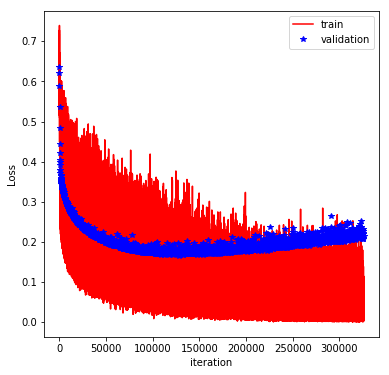

In [37]:
import matplotlib.pyplot as plt
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 100 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

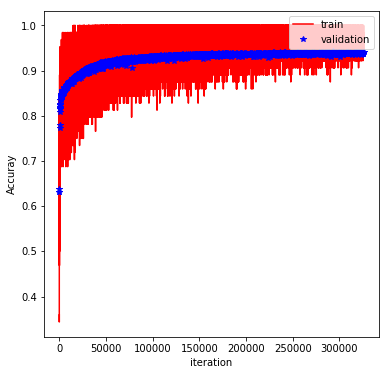

In [38]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 100 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [65]:
testStrings = '''4092,3677,1
4556,4555,1
4408,4242,1
62210,4133,1
4459,84509,1
6750,2896,1
3942,7158,1
3754,65157,1
3084,65157,1
6985,65157,1
3061,65157,1
27939,65157,1
4139,2915,1
3058,2937,1
4047,2937,1
7335,3010,1
3375,9343,1
4150,45921,1'''

X_test = []
y_test = []
X_test_reverse = []

for line in testStrings.splitlines():
    word = line.replace("\r\n", "").split(",")
    X_test.append([word[0], word[1]])
    X_test_reverse.append([word[1], word[0]])
    y_test.append(int(word[2]))
#     print(word)
#     print(vector_model.docvecs[word[0]])
#     print(vector_model.docvecs[word[1]])

print(len(X_test))

18


In [57]:
print(X_test)
print(y_test)

[['4092', '3677'], ['4556', '4555'], ['4408', '4242'], ['62210', '4133'], ['4459', '84509'], ['6750', '2896'], ['3942', '7158'], ['3754', '65157'], ['3084', '65157'], ['6985', '65157'], ['3061', '65157'], ['27939', '65157'], ['4139', '2915'], ['3058', '2937'], ['4047', '2937'], ['7335', '3010'], ['3375', '9343'], ['4150', '45921']]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [61]:
for pair in X_test:
    if pair in X_train or pair in X_validation:
        print(pair, ' yes')
        X_test.remove(pair)

print(len(X_test))

17


In [63]:
test_acc = []
batch_size = len(X_test)
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.352941


In [66]:
for pair in X_test_reverse:
    if pair in X_train or pair in X_validation:
        print(pair, ' yes')
        X_test.remove(pair)

print(len(X_test_reverse))

18


In [67]:
test_acc = []
batch_size = len(X_test)
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test_reverse, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.333333
